### Dice Coefficient 
##### This script is designed to quantify similarities and differences between two aspects of the visual pathway in object recognition.

In [ ]:
# FC and PPI dice coefficient
import os
import numpy as np
import pandas as pd
import nibabel as nib
from scipy import stats

# Define study directories
study_dir = "/lab_data/behrmannlab/vlad/ptoc"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
sub_info_path = '/user_data/csimmon2/git_repos/ptoc/sub_info.csv'
output_dir = f'{results_dir}/dice_comparison'
os.makedirs(output_dir, exist_ok=True)

def dice_coefficient(img1_data, img2_data):
    """Calculate Dice coefficient between two binary arrays."""
    # Ensure binary
    img1_bin = (img1_data > 0).astype(int)
    img2_bin = (img2_data > 0).astype(int)
    
    # Calculate intersection
    intersection = np.sum(img1_bin * img2_bin)
    
    # Calculate Dice using formula: 2*intersection/(sum of elements)
    dice = 2.0 * intersection / (np.sum(img1_bin) + np.sum(img2_bin))
    
    return dice

def analyze_data_type(analysis_type):
    """Analyze dice coefficients for a specific data type (fc or ppi)"""
    print(f"\n{'='*80}")
    print(f"ANALYZING {analysis_type.upper()} MAPS")
    print(f"{'='*80}")
    
    # Load subject info
    sub_info = pd.read_csv(sub_info_path)
    subjects = sub_info[sub_info['group'] == 'control']['sub'].tolist()
    
    # Exclude sub-084 as specified
    if 'sub-084' in subjects:
        subjects.remove('sub-084')
        print("Excluded sub-084 from analysis")
    
    print(f"Found {len(subjects)} control subjects")
    
    # Define ROIs and hemispheres
    rois = ['pIPS', 'LO']
    hemispheres = ['left', 'right']
    
    # Load and preprocess subject data
    subject_data = {}
    valid_subjects = []
    
    for sub in subjects:
        has_all_data = True
        subject_data[sub] = {}
        
        for roi in rois:
            # Initialize lists to store hemisphere data
            roi_data_arrays = []
            
            for hemi in hemispheres:
                # Both FC and PPI files are in the same directory but with different analysis_type in the filename
                roi_file = f'{study_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_{roi}_{hemi}_loc_{analysis_type}_mni.nii.gz'
                
                if os.path.exists(roi_file):
                    try:
                        img = nib.load(roi_file)
                        roi_data_arrays.append(img.get_fdata())
                    except Exception as e:
                        print(f"Error loading {roi_file}: {e}")
                        has_all_data = False
                else:
                    print(f"File not found: {roi_file}")
                    has_all_data = False
            
            # Average the hemispheres if we have data for both
            if len(roi_data_arrays) == 2:
                # Create averaged map
                avg_data = (roi_data_arrays[0] + roi_data_arrays[1]) / 2
                subject_data[sub][roi] = avg_data
            else:
                has_all_data = False
        
        if has_all_data:
            valid_subjects.append(sub)
    
    print(f"Found {len(valid_subjects)} subjects with complete {analysis_type} data")
    
    if len(valid_subjects) == 0:
        print(f"No valid subjects found for {analysis_type} analysis. Skipping.")
        return None
    
    # 1. Within-subject, between-ROI analysis (pIPS vs LO)
    print(f"\nCalculating within-subject, between-ROI dice coefficients for {analysis_type}...")
    between_roi_results = []
    
    for sub in valid_subjects:
        try:
            # Calculate Dice coefficient
            dice_score = dice_coefficient(subject_data[sub]['pIPS'], subject_data[sub]['LO'])
            
            between_roi_results.append({
                'Subject': sub,
                'Analysis': analysis_type,
                'Dice': dice_score
            })
            
            print(f"Subject {sub}, {analysis_type}, pIPS vs LO: {dice_score:.4f}")
        except Exception as e:
            print(f"Error processing subject {sub}: {e}")
    
    # Convert to DataFrame
    between_roi_df = pd.DataFrame(between_roi_results)
    
    # Calculate statistics
    mean = between_roi_df['Dice'].mean()
    std = between_roi_df['Dice'].std()
    # 95% confidence interval
    ci = stats.t.interval(0.95, len(between_roi_df)-1, loc=mean, scale=std/np.sqrt(len(between_roi_df)))
    
    print(f"\n{analysis_type.upper()}: pIPS vs LO within-subject similarity:")
    print(f"Mean Dice: {mean:.4f} ± {std:.4f}")
    print(f"95% CI: [{ci[0]:.4f}, {ci[1]:.4f}]")
    print(f"N = {len(between_roi_df)} subjects")
    
    # 2. Between-subject, within-ROI analysis
    print(f"\nCalculating between-subject, within-ROI dice coefficients for {analysis_type}...")
    within_roi_results = []
    
    for roi in rois:
        # Compare each subject to all others
        for i, sub1 in enumerate(valid_subjects):
            for j, sub2 in enumerate(valid_subjects):
                if i < j:  # Only compare each pair once
                    try:
                        # Calculate Dice coefficient
                        dice_score = dice_coefficient(subject_data[sub1][roi], subject_data[sub2][roi])
                        
                        within_roi_results.append({
                            'ROI': roi,
                            'Analysis': analysis_type,
                            'Subject1': sub1,
                            'Subject2': sub2,
                            'Dice': dice_score
                        })
                    except Exception as e:
                        print(f"Error comparing {sub1} and {sub2} for {roi}: {e}")
    
    # Convert to DataFrame
    within_roi_df = pd.DataFrame(within_roi_results)
    
    # Calculate statistics for each ROI
    within_roi_stats = []
    
    for roi in rois:
        roi_data = within_roi_df[within_roi_df['ROI'] == roi]
        
        if len(roi_data) > 0:
            mean = roi_data['Dice'].mean()
            std = roi_data['Dice'].std()
            # 95% confidence interval
            ci = stats.t.interval(0.95, len(roi_data)-1, loc=mean, scale=std/np.sqrt(len(roi_data)))
            
            within_roi_stats.append({
                'ROI': roi,
                'Analysis': analysis_type,
                'Mean Dice': mean,
                'Std Dev': std,
                '95% CI Lower': ci[0],
                '95% CI Upper': ci[1],
                'N': len(roi_data)
            })
            
            print(f"\n{analysis_type.upper()}: {roi} between-subject similarity:")
            print(f"Mean Dice: {mean:.4f} ± {std:.4f}")
            print(f"95% CI: [{ci[0]:.4f}, {ci[1]:.4f}]")
            print(f"Based on {len(roi_data)} comparisons among {len(valid_subjects)} subjects")
    
    # Save results to CSV files
    between_roi_df.to_csv(f'{output_dir}/{analysis_type}_between_roi_dice_by_subject.csv', index=False)
    within_roi_df.to_csv(f'{output_dir}/{analysis_type}_within_roi_dice_by_pair.csv', index=False)
    
    within_roi_stats_df = pd.DataFrame(within_roi_stats)
    within_roi_stats_df.to_csv(f'{output_dir}/{analysis_type}_within_roi_stats.csv', index=False)
    
    # Prepare summary data
    between_roi_stats = {
        'ROI': 'pIPS vs LO',
        'Analysis': analysis_type,
        'Mean Dice': between_roi_df['Dice'].mean(),
        'Std Dev': between_roi_df['Dice'].std(),
        '95% CI Lower': ci[0],
        '95% CI Upper': ci[1],
        'N': len(between_roi_df)
    }
    
    # Combine all stats into one DataFrame
    all_stats = pd.DataFrame([between_roi_stats] + within_roi_stats)
    
    return {
        'between_roi': between_roi_df,
        'within_roi': within_roi_df,
        'stats': all_stats
    }

def main():
    """Analyze both FC and PPI data"""
    results = {}
    all_stats = []
    
    # Analyze FC data
    print("\nAnalyzing FC data...")
    fc_results = analyze_data_type('fc')
    if fc_results:
        results['fc'] = fc_results
        all_stats.append(fc_results['stats'])
    
    # Analyze PPI data
    print("\nAnalyzing PPI data...")
    ppi_results = analyze_data_type('ppi')
    if ppi_results:
        results['ppi'] = ppi_results
        all_stats.append(ppi_results['stats'])
    
    # Combine stats from both analyses
    if all_stats:
        combined_stats = pd.concat(all_stats)
        combined_stats.to_csv(f'{output_dir}/combined_dice_stats.csv', index=False)
        
        # Print combined summary
        print("\n\nCOMBINED SUMMARY OF DICE COEFFICIENT ANALYSES")
        print("=" * 80)
        print(combined_stats.to_string(index=False))
        
        # Create comparison table for FC vs PPI
        if 'fc' in results and 'ppi' in results:
            comparison = combined_stats.pivot(index='ROI', columns='Analysis', values='Mean Dice')
            comparison['Difference'] = comparison['ppi'] - comparison['fc']
            
            print("\n\nFC vs PPI COMPARISON")
            print("=" * 80)
            print(comparison.to_string())
            
            comparison.to_csv(f'{output_dir}/fc_vs_ppi_comparison.csv')
    
    return results

if __name__ == "__main__":
    results = main()

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (



Analyzing FC data...

ANALYZING FC MAPS
Excluded sub-084 from analysis
Found 18 control subjects
Found 18 subjects with complete fc data

Calculating within-subject, between-ROI dice coefficients for fc...
Subject sub-025, fc, pIPS vs LO: 0.7674
Subject sub-038, fc, pIPS vs LO: 0.8994
Subject sub-057, fc, pIPS vs LO: 0.9702
Subject sub-059, fc, pIPS vs LO: 0.9561
Subject sub-064, fc, pIPS vs LO: 0.8788
Subject sub-067, fc, pIPS vs LO: 0.9832
Subject sub-068, fc, pIPS vs LO: 0.9224
Subject sub-071, fc, pIPS vs LO: 0.9688
Subject sub-083, fc, pIPS vs LO: 0.9507
Subject sub-085, fc, pIPS vs LO: 0.8597
Subject sub-087, fc, pIPS vs LO: 0.9086
Subject sub-088, fc, pIPS vs LO: 0.9605
Subject sub-093, fc, pIPS vs LO: 0.9523
Subject sub-094, fc, pIPS vs LO: 0.8894
Subject sub-095, fc, pIPS vs LO: 0.9449
Subject sub-096, fc, pIPS vs LO: 0.9090
Subject sub-097, fc, pIPS vs LO: 0.8686
Subject sub-107, fc, pIPS vs LO: 0.8695

FC: pIPS vs LO within-subject similarity:
Mean Dice: 0.9144 ± 0.0539
95%

In [ ]:
# Dice coefficient ANOVA
import os
import numpy as np
import pandas as pd
import nibabel as nib
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from statsmodels.stats.multitest import multipletests

def compare_within_vs_between_dice_anova_averaged(analysis_type='fc'):
    """
    Independent function to compare within-ROI vs between-ROI dice coefficients 
    using ANOVA with subject-level averages for better statistical properties.
    Now supports both FC and PPI analysis types.
    
    Parameters:
    -----------
    analysis_type : str
        Type of analysis to perform, either 'fc' or 'ppi'
    """
    # Define study directories
    study_dir = "/lab_data/behrmannlab/vlad/ptoc"
    results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
    sub_info_path = '/user_data/csimmon2/git_repos/ptoc/sub_info.csv'
    output_dir = f'{results_dir}/dice_comparison'
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"Comparing within-ROI vs between-ROI dice coefficients using ANOVA with subject averages for {analysis_type.upper()}...")
    
    # Load subject info
    sub_info = pd.read_csv(sub_info_path)
    subjects = sub_info[sub_info['group'] == 'control']['sub'].tolist()
    
    # Exclude sub-084 as specified
    if 'sub-084' in subjects:
        subjects.remove('sub-084')
        print("Excluded sub-084 from analysis")
    
    print(f"Found {len(subjects)} control subjects")
    
    # Define ROIs and hemispheres
    rois = ['pIPS', 'LO']
    hemispheres = ['left', 'right']
    
    # Load and preprocess subject data
    subject_data = {}
    valid_subjects = []
    
    for sub in subjects:
        has_all_data = True
        subject_data[sub] = {}
        
        for roi in rois:
            # Initialize lists to store hemisphere data
            roi_data_arrays = []
            
            for hemi in hemispheres:
                roi_file = f'{study_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_{roi}_{hemi}_loc_{analysis_type}_mni.nii.gz'
                
                if os.path.exists(roi_file):
                    try:
                        img = nib.load(roi_file)
                        roi_data_arrays.append(img.get_fdata())
                    except Exception as e:
                        print(f"Error loading {roi_file}: {e}")
                        has_all_data = False
                else:
                    print(f"File not found: {roi_file}")
                    has_all_data = False
            
            # Average the hemispheres if we have data for both
            if len(roi_data_arrays) == 2:
                # Create averaged map
                avg_data = (roi_data_arrays[0] + roi_data_arrays[1]) / 2
                subject_data[sub][roi] = (avg_data > 0).astype(int)  # Binarize
            else:
                has_all_data = False
        
        if has_all_data:
            valid_subjects.append(sub)
    
    print(f"Found {len(valid_subjects)} subjects with complete {analysis_type} data")
    
    if len(valid_subjects) == 0:
        print(f"No valid subjects found for {analysis_type} analysis. Skipping.")
        return None
    
    # 1. Within-subject, between-ROI analysis (pIPS vs LO)
    print(f"\nCalculating within-subject, between-ROI dice coefficients for {analysis_type}...")
    between_roi_results = []
    
    for sub in valid_subjects:
        try:
            # Get binary maps
            pips_bin = subject_data[sub]['pIPS']
            lo_bin = subject_data[sub]['LO']
            
            # Calculate intersection
            intersection = np.sum(pips_bin * lo_bin)
            
            # Calculate Dice
            dice_score = 2.0 * intersection / (np.sum(pips_bin) + np.sum(lo_bin))
            
            between_roi_results.append({
                'Subject': sub,
                'Dice': dice_score,
                'Comparison': 'Within-subject_between-ROI'
            })
            
            print(f"Subject {sub}, pIPS vs LO: {dice_score:.4f}")
        except Exception as e:
            print(f"Error processing subject {sub}: {e}")
    
    # 2. Calculate all pairwise between-subject dice coefficients
    print(f"\nCalculating pairwise between-subject, within-ROI dice coefficients for {analysis_type}...")
    pairwise_results = {}
    
    for roi in rois:
        pairwise_results[roi] = {}
        # Initialize the nested dictionary structure
        for sub in valid_subjects:
            pairwise_results[roi][sub] = {}
        
        # Compare each subject to all others
        for i, sub1 in enumerate(valid_subjects):
            for j, sub2 in enumerate(valid_subjects):
                if i < j:  # Only compare each pair once
                    try:
                        # Get binary maps
                        map1 = subject_data[sub1][roi]
                        map2 = subject_data[sub2][roi]
                        
                        # Calculate intersection
                        intersection = np.sum(map1 * map2)
                        
                        # Calculate Dice
                        dice_score = 2.0 * intersection / (np.sum(map1) + np.sum(map2))
                        
                        # Store the result for both subjects
                        pairwise_results[roi][sub1][sub2] = dice_score
                        pairwise_results[roi][sub2][sub1] = dice_score
                    except Exception as e:
                        print(f"Error comparing {sub1} and {sub2} for {roi}: {e}")
    
    # 3. Average the between-subject dice coefficients for each subject
    print(f"\nAveraging between-subject dice coefficients for each subject for {analysis_type}...")
    average_results = []
    
    for roi in rois:
        for sub in pairwise_results[roi]:
            # Calculate the average dice with all other subjects
            if len(pairwise_results[roi][sub]) > 0:  # Ensure there are values to average
                avg_dice = np.mean(list(pairwise_results[roi][sub].values()))
                
                average_results.append({
                    'Subject': sub,
                    'ROI': roi,
                    'Dice': avg_dice,
                    'Comparison': f'Between-subject_within-{roi}'
                })
                print(f"Subject {sub}, average {roi} similarity with other subjects: {avg_dice:.4f}")
    
    # Combine results for ANOVA
    all_results = pd.DataFrame(between_roi_results)
    average_df = pd.DataFrame(average_results)
    
    # Create separate DataFrames for pIPS and LO
    pips_df = average_df[average_df['ROI'] == 'pIPS'].copy()
    lo_df = average_df[average_df['ROI'] == 'LO'].copy()
    
    # Calculate summary statistics
    print(f"\nSummary Statistics for {analysis_type.upper()}:")
    
    groups = {
        'Within-subject, between-ROI': all_results['Dice'].values,
        'Between-subject, within-pIPS': pips_df['Dice'].values,
        'Between-subject, within-LO': lo_df['Dice'].values
    }
    
    for group_name, values in groups.items():
        if len(values) > 0:
            mean = np.mean(values)
            std = np.std(values)
            ci = stats.t.interval(0.95, len(values)-1, loc=mean, scale=std/np.sqrt(len(values)))
            print(f"{group_name}:")
            print(f"  N = {len(values)}")
            print(f"  Mean = {mean:.4f} ± {std:.4f}")
            print(f"  95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")
    
    # Save summary statistics to CSV
    summary_stats = []
    for group_name, values in groups.items():
        if len(values) > 0:
            mean = np.mean(values)
            std = np.std(values)
            ci = stats.t.interval(0.95, len(values)-1, loc=mean, scale=std/np.sqrt(len(values)))
            summary_stats.append({
                'Analysis': analysis_type,
                'Group': group_name,
                'N': len(values),
                'Mean': mean,
                'Std': std,
                'CI_Lower': ci[0],
                'CI_Upper': ci[1]
            })
    
    summary_df = pd.DataFrame(summary_stats)
    summary_df.to_csv(f'{output_dir}/{analysis_type}_anova_summary_stats.csv', index=False)
    
    # Prepare data for ANOVA - now all groups should have the same sample size based on valid subjects
    anova_data = pd.DataFrame({
        'Dice': np.concatenate([
            all_results['Dice'].values,
            pips_df['Dice'].values,
            lo_df['Dice'].values
        ]),
        'Group': np.concatenate([
            ['Within-subject_between-ROI'] * len(all_results),
            ['Between-subject_within-pIPS'] * len(pips_df),
            ['Between-subject_within-LO'] * len(lo_df)
        ])
    })
    
    # Run One-way ANOVA
    print(f"\nPerforming One-way ANOVA with subject averages for {analysis_type}...")
    model = ols('Dice ~ C(Group)', data=anova_data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    print("\nANOVA Results:")
    print(anova_table)
    
    # Save ANOVA results to CSV
    anova_df = pd.DataFrame(anova_table)
    anova_df.to_csv(f'{output_dir}/{analysis_type}_anova_results.csv')
    

    # Calculate pairwise t-tests and apply Holm-Bonferroni correction
    unique_groups = anova_data['Group'].unique()
    p_values = []
    pairs = []

    for i, group1 in enumerate(unique_groups):
        for j, group2 in enumerate(unique_groups):
            if i < j:  # Compare each pair only once
                data1 = anova_data[anova_data['Group'] == group1]['Dice']
                data2 = anova_data[anova_data['Group'] == group2]['Dice']
                _, p_val = stats.ttest_ind(data1, data2, equal_var=False)
                p_values.append(p_val)
                pairs.append((group1, group2))

    # Apply Holm-Bonferroni correction
    reject, p_corrected, _, _ = multipletests(p_values, alpha=0.05, method='holm')

    # Print results
    print("\nHolm-Bonferroni Results:")
    for i, ((group1, group2), p_corr, rej) in enumerate(zip(pairs, p_corrected, reject)):
        print(f"{group1} vs {group2}: p-corrected = {p_corr:.4f}, significant: {rej}")

    # Save results to a text file
    with open(f'{output_dir}/{analysis_type}_holm_bonferroni_results.txt', 'w') as f:
        f.write("Holm-Bonferroni corrected pairwise comparisons:\n\n")
        for i, ((group1, group2), p_corr, rej) in enumerate(zip(pairs, p_corrected, reject)):
            f.write(f"{group1} vs {group2}: p-corrected = {p_corr:.4f}, significant: {rej}\n")
    
    # Print interpretation
    print(f"\nINTERPRETATION for {analysis_type.upper()}:")
    f_value = anova_table['F'][0]
    p_value = anova_table['PR(>F)'][0]
    
    if p_value < 0.05:
        print(f"The ANOVA shows significant differences in Dice coefficients among the three comparison types (F={f_value:.4f}, p={p_value:.4f}).")
        print("The Holm Bonferroni post-hoc test shows which specific groups differ from each other.")
        print("\nBased on the means:")
        
        means = {
            'Within-subject_between-ROI': np.mean(groups['Within-subject, between-ROI']),
            'Between-subject_within-pIPS': np.mean(groups['Between-subject, within-pIPS']),
            'Between-subject_within-LO': np.mean(groups['Between-subject, within-LO'])
        }
        
        ordered_groups = sorted(means.items(), key=lambda x: x[1], reverse=True)
        
        for i, (group, mean) in enumerate(ordered_groups):
            print(f"{i+1}. {group}: {mean:.4f}")
        
        if means['Within-subject_between-ROI'] > means['Between-subject_within-pIPS'] and means['Within-subject_between-ROI'] > means['Between-subject_within-LO']:
            print("\nThis suggests that different ROIs within the same subject share more similar connectivity patterns")
            print("than the same ROI across different subjects. This pattern holds for both pIPS and LO.")
        else:
            print("\nThe pattern suggests a more complex relationship. Please refer to the Holm-Bon results for specific group differences.")
    else:
        print(f"The ANOVA shows no significant differences in Dice coefficients among the three comparison types (F={f_value:.4f}, p={p_value:.4f}).")
        print("This suggests that the level of similarity does not significantly differ between:")
        print("- different ROIs within the same subject")
        print("- the same ROI across different subjects")
    
    return {
        'anova_table': anova_table,
        'holm_result': {
            'pairs': pairs,
            'p_corrected': p_corrected,
            'reject': reject
        },
        'group_means': {
            'Within-subject_between-ROI': np.mean(groups['Within-subject, between-ROI']),
            'Between-subject_within-pIPS': np.mean(groups['Between-subject, within-pIPS']),
            'Between-subject_within-LO': np.mean(groups['Between-subject, within-LO'])
        }
    }

def main():
    """Run ANOVA comparisons for both FC and PPI data"""
    results = {}
    
    # Analyze FC data
    print("\nAnalyzing FC data...")
    fc_results = compare_within_vs_between_dice_anova_averaged('fc')
    if fc_results:
        results['fc'] = fc_results
    
    # Analyze PPI data
    print("\nAnalyzing PPI data...")
    ppi_results = compare_within_vs_between_dice_anova_averaged('ppi')
    if ppi_results:
        results['ppi'] = ppi_results
    
    # Compare FC vs PPI results if both analyses completed successfully
    if 'fc' in results and 'ppi' in results:
        print("\n\nCOMPARING FC vs PPI RESULTS")
        print("=" * 80)
        
        # Create comparison table
        comparison = {
            'Group': list(results['fc']['group_means'].keys()),
            'FC_Mean': list(results['fc']['group_means'].values()),
            'PPI_Mean': list(results['ppi']['group_means'].values())
        }
        
        comparison_df = pd.DataFrame(comparison)
        comparison_df['Difference'] = comparison_df['PPI_Mean'] - comparison_df['FC_Mean']
        
        print(comparison_df.to_string(index=False))
        
        # Save comparison to CSV
        output_dir = f'/user_data/csimmon2/git_repos/ptoc/results/dice_comparison'
        comparison_df.to_csv(f'{output_dir}/fc_vs_ppi_anova_comparison.csv', index=False)
        
        # Provide interpretation of differences
        print("\nINTERPRETATION OF FC vs PPI COMPARISON:")
        for group in comparison_df['Group']:
            fc_mean = results['fc']['group_means'][group]
            ppi_mean = results['ppi']['group_means'][group]
            diff = ppi_mean - fc_mean
            
            if abs(diff) < 0.01:
                print(f"- {group}: Very similar Dice coefficients between FC and PPI (diff: {diff:.4f})")
            elif diff > 0:
                print(f"- {group}: PPI shows higher similarity than FC (diff: {diff:.4f})")
            else:
                print(f"- {group}: FC shows higher similarity than PPI (diff: {diff:.4f})")
    
    return results

if __name__ == "__main__":
    results = main()


Analyzing FC data...
Comparing within-ROI vs between-ROI dice coefficients using ANOVA with subject averages for FC...
Excluded sub-084 from analysis
Found 18 control subjects
Found 18 subjects with complete fc data

Calculating within-subject, between-ROI dice coefficients for fc...
Subject sub-025, pIPS vs LO: 0.7674
Subject sub-038, pIPS vs LO: 0.8994
Subject sub-057, pIPS vs LO: 0.9702
Subject sub-059, pIPS vs LO: 0.9561
Subject sub-064, pIPS vs LO: 0.8788
Subject sub-067, pIPS vs LO: 0.9832
Subject sub-068, pIPS vs LO: 0.9224
Subject sub-071, pIPS vs LO: 0.9688
Subject sub-083, pIPS vs LO: 0.9507
Subject sub-085, pIPS vs LO: 0.8597
Subject sub-087, pIPS vs LO: 0.9086
Subject sub-088, pIPS vs LO: 0.9605
Subject sub-093, pIPS vs LO: 0.9523
Subject sub-094, pIPS vs LO: 0.8894
Subject sub-095, pIPS vs LO: 0.9449
Subject sub-096, pIPS vs LO: 0.9090
Subject sub-097, pIPS vs LO: 0.8686
Subject sub-107, pIPS vs LO: 0.8695

Calculating pairwise between-subject, within-ROI dice coefficient

/tmp/ipykernel_22760/1006248671.py:269: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]
/tmp/ipykernel_22760/1006248671.py:270: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]


Found 18 subjects with complete ppi data

Calculating within-subject, between-ROI dice coefficients for ppi...
Subject sub-025, pIPS vs LO: 0.7072
Subject sub-038, pIPS vs LO: 0.7988
Subject sub-057, pIPS vs LO: 0.9275
Subject sub-059, pIPS vs LO: 0.8801
Subject sub-064, pIPS vs LO: 0.6038
Subject sub-067, pIPS vs LO: 0.7652
Subject sub-068, pIPS vs LO: 0.8257
Subject sub-071, pIPS vs LO: 0.8305
Subject sub-083, pIPS vs LO: 0.7645
Subject sub-085, pIPS vs LO: 0.8298
Subject sub-087, pIPS vs LO: 0.8670
Subject sub-088, pIPS vs LO: 0.8273
Subject sub-093, pIPS vs LO: 0.9517
Subject sub-094, pIPS vs LO: 0.7325
Subject sub-095, pIPS vs LO: 0.8934
Subject sub-096, pIPS vs LO: 0.7577
Subject sub-097, pIPS vs LO: 0.8600
Subject sub-107, pIPS vs LO: 0.8003

Calculating pairwise between-subject, within-ROI dice coefficients for ppi...

Averaging between-subject dice coefficients for each subject for ppi...
Subject sub-025, average pIPS similarity with other subjects: 0.4946
Subject sub-038, ave

/tmp/ipykernel_22760/1006248671.py:269: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]
/tmp/ipykernel_22760/1006248671.py:270: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]


Visualizing FC analysis...


/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/image/resampling.py:591: UserWarning: Casting data from int64 to float64
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")
/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/image/resampling.py:591: UserWarning: Casting data from int64 to float64
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")
/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/image/resampling.py:292: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  "Resampling binary images with continuous or "


Found optimal coordinates for fc: (54.0, -28.0, 48.0)


/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/ipykernel_launcher.py:183: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Saved FC visualization to: /user_data/csimmon2/git_repos/ptoc/results/pIPS_LO_merged_fc_overlap_binary.png

Overlap Statistics for FC:
Total pIPS voxels: 39965
Total LO voxels: 29475
Total overlap voxels: 24406
Overlap percentage: 54.19%
Dice coefficient: 0.7029
Created FC overlap visualization at coordinates (54.0, -28.0, 48.0)
Visualizing PPI analysis...


/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/image/resampling.py:591: UserWarning: Casting data from int64 to float64
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")
/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/image/resampling.py:591: UserWarning: Casting data from int64 to float64
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")
/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/image/resampling.py:292: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  "Resampling binary images with continuous or "


Found optimal coordinates for ppi: (48.0, -20.0, 52.0)


/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/ipykernel_launcher.py:183: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Saved PPI visualization to: /user_data/csimmon2/git_repos/ptoc/results/pIPS_LO_merged_ppi_overlap_binary.png

Overlap Statistics for PPI:
Total pIPS voxels: 22652
Total LO voxels: 18054
Total overlap voxels: 15023
Overlap percentage: 58.49%
Dice coefficient: 0.7381
Created PPI overlap visualization at coordinates (48.0, -20.0, 52.0)


/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/image/resampling.py:591: UserWarning: Casting data from int64 to float64
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")
/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/image/resampling.py:591: UserWarning: Casting data from int64 to float64
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")
/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/image/resampling.py:292: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  "Resampling binary images with continuous or "
/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/image/resampling.py:591: UserWarning: Casting data from int64 to float64
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")
/home/csimmon2/anacond

Saved FC vs PPI comparison to: /user_data/csimmon2/git_repos/ptoc/results/pIPS_LO_FC_vs_PPI_comparison.png
Created combined FC vs PPI comparison visualization


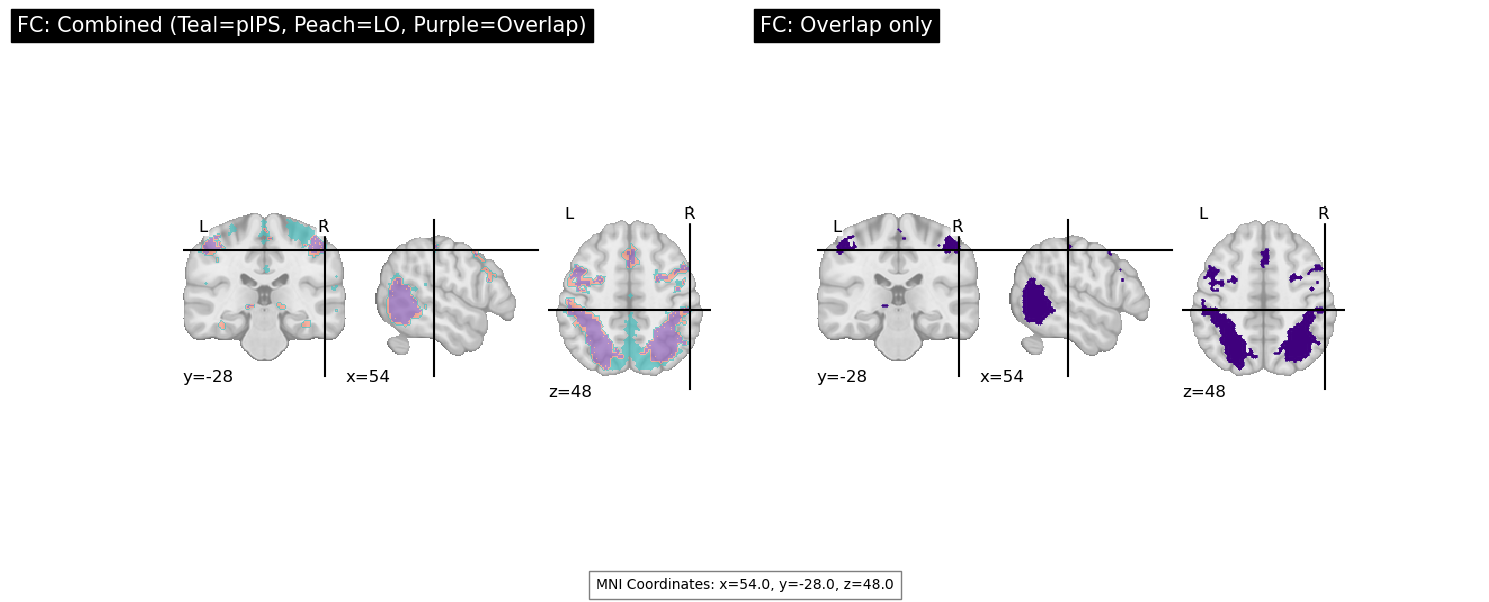

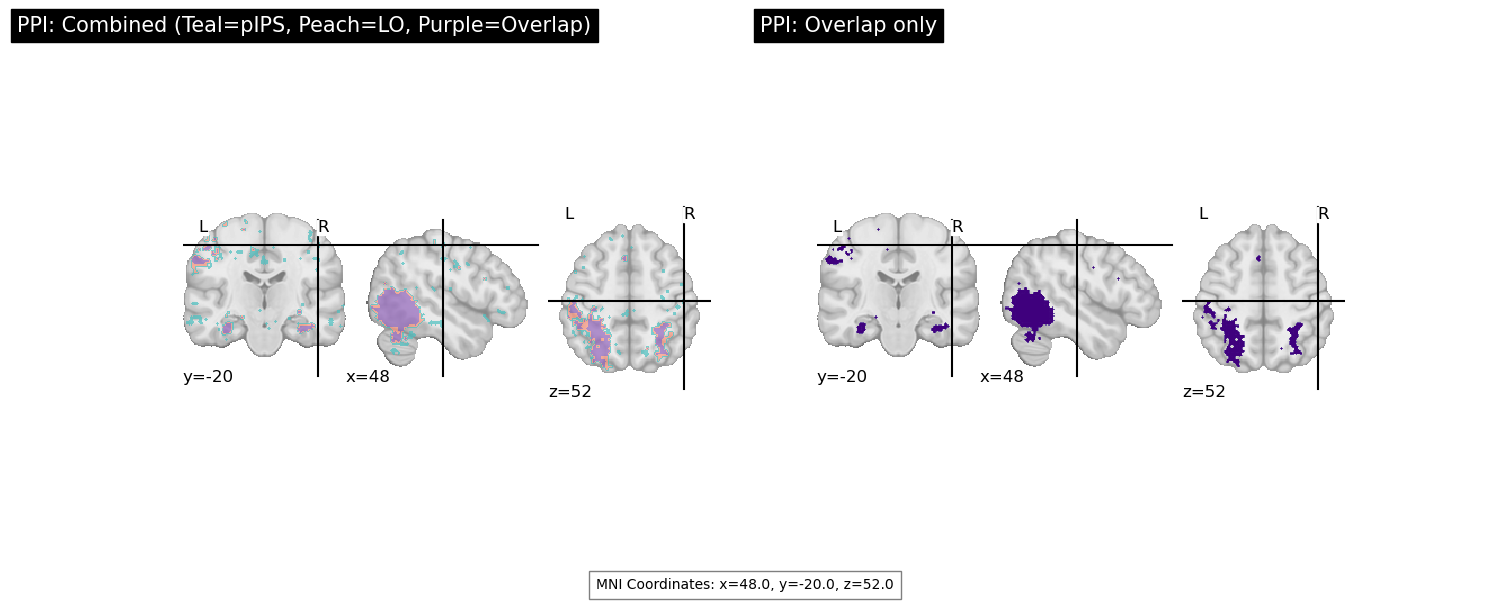

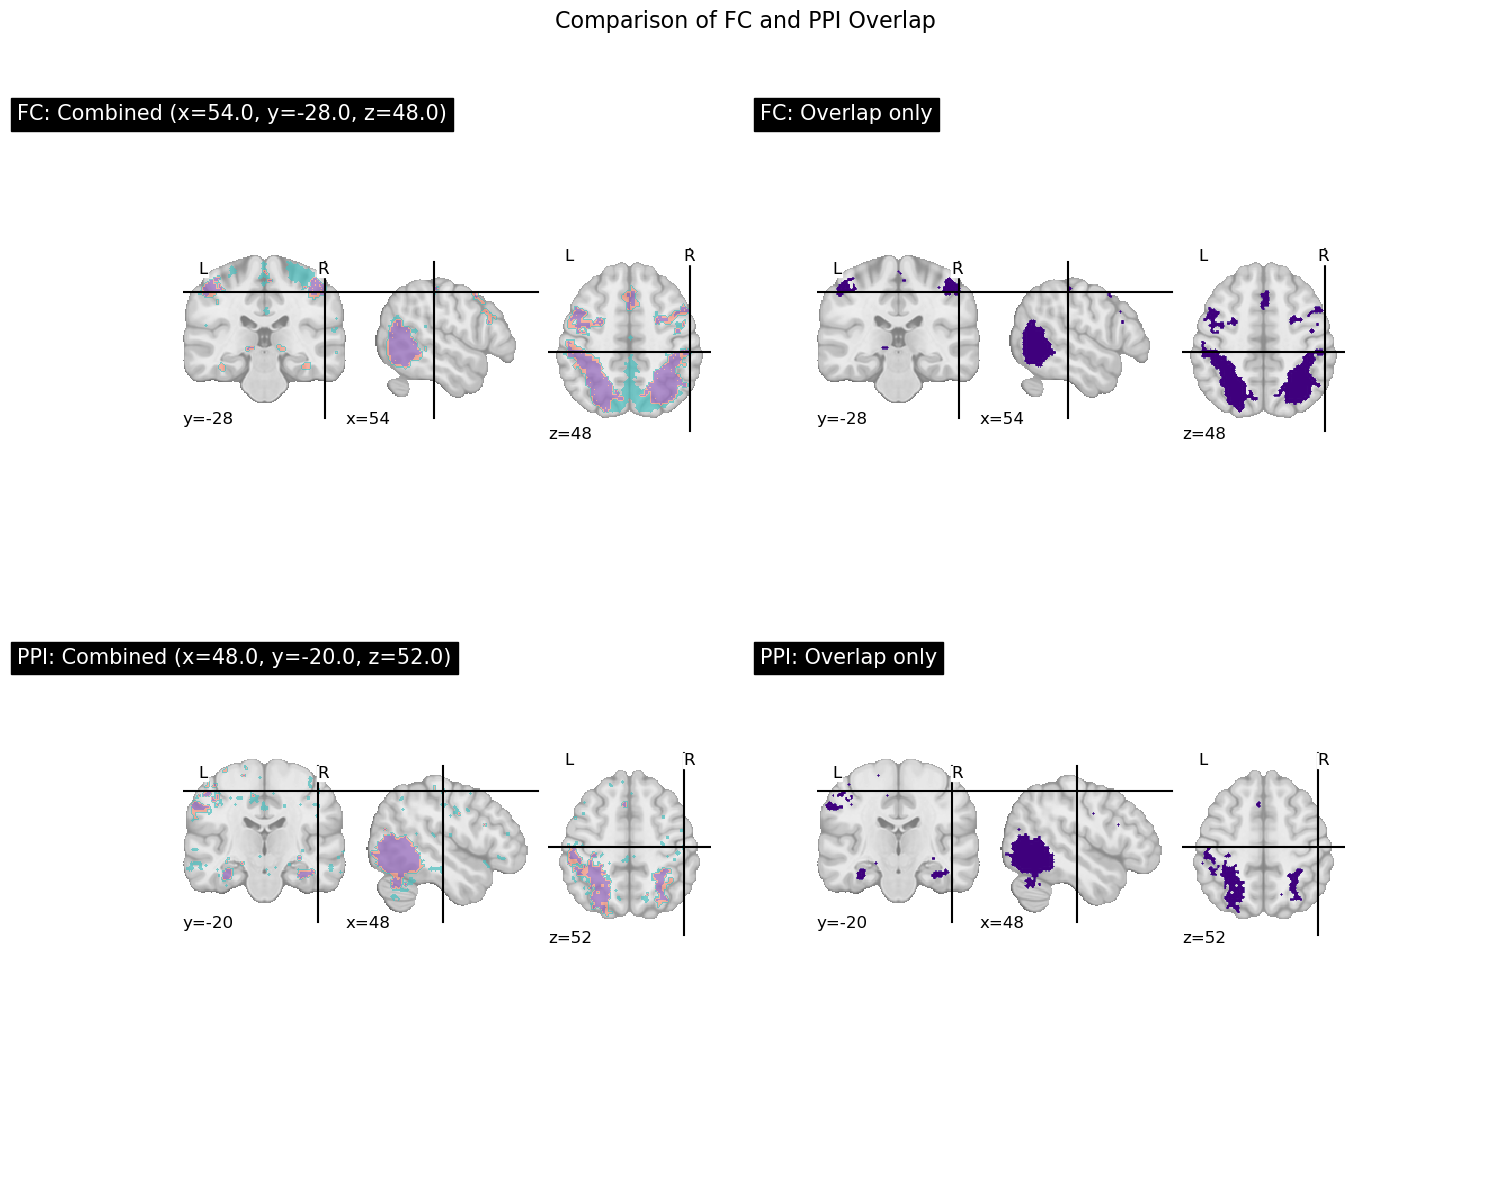

In [ ]:
# Visualize overlap - FC and PPI
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn import datasets
from nilearn.image import resample_to_img
from matplotlib.colors import ListedColormap

# Define study directories
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
group_out_dir = f'{results_dir}/group_averages'

def find_peak_activation(img_data, affine):
    """
    Find the coordinates of peak activation in dorsal regions.
    
    Parameters:
    -----------
    img_data : numpy.ndarray
        Image data array
    affine : numpy.ndarray
        Affine transformation matrix
    
    Returns:
    --------
    tuple
        (x, y, z) coordinates in MNI space
    """
    # Define dorsal region (z > 40mm in MNI space)
    dorsal_mask = np.zeros_like(img_data, dtype=bool)
    
    for x in range(img_data.shape[0]):
        for y in range(img_data.shape[1]):
            for z in range(img_data.shape[2]):
                mni_coords = nib.affines.apply_affine(affine, [x, y, z])
                if mni_coords[2] > 40:  # z > 40mm (dorsal)
                    dorsal_mask[x, y, z] = True
    
    # Apply mask
    masked_data = img_data * dorsal_mask
    
    # Find peak activation
    if np.max(masked_data) > 0:
        peak_idx = np.unravel_index(np.argmax(masked_data), masked_data.shape)
        peak_mni = nib.affines.apply_affine(affine, peak_idx)
        return tuple(peak_mni)
    else:
        # Default coordinates if no peak found
        return (30, -60, 50)

def main(analysis_type='fc', cut_coords=None):
    """
    Simple visualization of pIPS and LO overlap with optimized coordinates.
    
    Parameters:
    -----------
    analysis_type : str
        Analysis type to visualize ('fc' or 'ppi')
    cut_coords : tuple or None
        (x, y, z) cut coordinates in MNI space, or None to find automatically
    """
    print(f"Visualizing {analysis_type.upper()} analysis...")
    
    # Define colors to match the violin plot
    pips_color = '#4ac0c0'  # Teal for pIPS
    lo_color = '#ff9b83'    # Peach for LO
    overlap_color = '#9467bd'  # Purple for overlap
    
    hemispheres = ['left', 'right']
    
    # Load MNI template
    template = datasets.load_mni152_template(resolution=1)
    
    # Load images for both hemispheres for each ROI
    pips_imgs = []
    lo_imgs = []
    
    for hemi in hemispheres:
        # Define file paths
        pips_img_path = f'{group_out_dir}/pIPS_{hemi}_{analysis_type}_thresh.nii.gz'
        lo_img_path = f'{group_out_dir}/LO_{hemi}_{analysis_type}_thresh.nii.gz'
        
        # Check if files exist
        if not os.path.exists(pips_img_path) or not os.path.exists(lo_img_path):
            print(f"Warning: Files not found for {hemi} hemisphere, {analysis_type}. Skipping.")
            continue
        
        # Load images
        pips_imgs.append(nib.load(pips_img_path))
        lo_imgs.append(nib.load(lo_img_path))
    
    # Skip if we don't have images for both hemispheres
    if len(pips_imgs) != 2 or len(lo_imgs) != 2:
        print(f"Warning: Missing data for one or more hemispheres in {analysis_type}. Skipping.")
        return
    
    # Create averaged hemisphere maps
    # Get the affine and header from the first image
    affine = pips_imgs[0].affine
    header = pips_imgs[0].header
    
    # Create average maps for each ROI
    pips_avg_data = (pips_imgs[0].get_fdata() + pips_imgs[1].get_fdata()) / 2
    lo_avg_data = (lo_imgs[0].get_fdata() + lo_imgs[1].get_fdata()) / 2
    
    # Create NIfTI images from the averaged data
    pips_avg_img = nib.Nifti1Image(pips_avg_data, affine, header)
    lo_avg_img = nib.Nifti1Image(lo_avg_data, affine, header)
    
    # Calculate binary maps for computation
    pips_binary = (pips_avg_data > 0).astype(int)
    lo_binary = (lo_avg_data > 0).astype(int)
    
    # Create overlap map (1=pIPS only, 2=LO only, 3=overlap)
    overlap_data = np.zeros_like(pips_binary)
    overlap_data[pips_binary == 1] = 1  # pIPS only
    overlap_data[lo_binary == 1] = 2    # LO only
    overlap_data[(pips_binary == 1) & (lo_binary == 1)] = 3  # Overlap
    
    # Create the overlap-only map as binary (1 where overlap occurs, 0 elsewhere)
    overlap_only_data = np.zeros_like(overlap_data)
    overlap_only_data[(pips_binary == 1) & (lo_binary == 1)] = 1
    
    # Create images
    overlap_img = nib.Nifti1Image(overlap_data, affine, header)
    overlap_only_img = nib.Nifti1Image(overlap_only_data, affine, header)
    
    # Resample images to match template resolution for better visualization
    overlap_resampled = resample_to_img(overlap_img, template)
    overlap_only_resampled = resample_to_img(overlap_only_img, template)
    
    # Find optimal cut coordinates if not provided
    if cut_coords is None:
        # Try to find coordinates based on overlap
        if np.sum(overlap_only_data) > 0:
            cut_coords = find_peak_activation(overlap_only_data, affine)
            print(f"Found optimal coordinates for {analysis_type}: {cut_coords}")
        else:
            # Try to find coordinates based on pIPS
            cut_coords = find_peak_activation(pips_avg_data, affine)
            print(f"Found pIPS coordinates for {analysis_type}: {cut_coords}")
    
    # Create figure with just the two panels
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Custom colormap for overlap visualization using the matching colors
    overlap_cmap = ListedColormap(['#00000000', pips_color, lo_color, overlap_color])
    
    # Plot combined map with overlap (left)
    display1 = plotting.plot_roi(
        roi_img=overlap_resampled,
        bg_img=template,
        display_mode='ortho',
        cut_coords=cut_coords,
        colorbar=False,
        cmap=overlap_cmap,
        title=f'{analysis_type.upper()}: Combined (Teal=pIPS, Peach=LO, Purple=Overlap)',
        axes=axes[0],
        black_bg=False
    )
    
    # Plot overlap-only map (right)
    display2 = plotting.plot_stat_map(
        stat_map_img=overlap_only_resampled,
        bg_img=template,
        display_mode='ortho',
        cut_coords=cut_coords,
        colorbar=False,
        cmap='Purples',  # Using a built-in purple colormap
        threshold=0.5,   # Only show values above 0.5 to ensure binary representation
        vmax=1.0,        # Set max value to 1.0
        title=f'{analysis_type.upper()}: Overlap only',
        axes=axes[1],
        black_bg=False
    )
    
    # Add a text annotation with the coordinates
    plt.figtext(0.5, 0.01, f"MNI Coordinates: x={cut_coords[0]:.1f}, y={cut_coords[1]:.1f}, z={cut_coords[2]:.1f}", 
                ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 1])
    
    # Save the figure
    plt.savefig(f'{results_dir}/pIPS_LO_merged_{analysis_type}_overlap_binary.png', dpi=300)
    print(f"Saved {analysis_type.upper()} visualization to: {results_dir}/pIPS_LO_merged_{analysis_type}_overlap_binary.png")
    
    # Calculate overlap statistics
    total_pips_voxels = np.sum(pips_binary)
    total_lo_voxels = np.sum(lo_binary)
    total_overlap_voxels = np.sum(overlap_only_data)
    
    # Calculate Dice coefficient
    if (total_pips_voxels + total_lo_voxels) > 0:
        dice_coef = 2 * total_overlap_voxels / (total_pips_voxels + total_lo_voxels)
    else:
        dice_coef = 0
        
    # Print statistics
    print(f"\nOverlap Statistics for {analysis_type.upper()}:")
    print(f"Total pIPS voxels: {total_pips_voxels}")
    print(f"Total LO voxels: {total_lo_voxels}")
    print(f"Total overlap voxels: {total_overlap_voxels}")
    print(f"Overlap percentage: {total_overlap_voxels/max(1, total_pips_voxels + total_lo_voxels - total_overlap_voxels)*100:.2f}%")
    print(f"Dice coefficient: {dice_coef:.4f}")
    
    return fig, cut_coords

def create_combined_figure(fc_coords, ppi_coords):
    """
    Create a combined figure showing FC and PPI results side by side
    with their respective optimal coordinates.
    
    Parameters:
    -----------
    fc_coords : tuple
        (x, y, z) coordinates for FC visualization
    ppi_coords : tuple
        (x, y, z) coordinates for PPI visualization
    """
    # Define analysis types
    analysis_types = ['fc', 'ppi']
    coords = [fc_coords, ppi_coords]
    
    # Create figure with 2 rows, 2 columns
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Comparison of FC and PPI Overlap', fontsize=16)
    
    # Define colors
    pips_color = '#4ac0c0'  # Teal for pIPS
    lo_color = '#ff9b83'    # Peach for LO
    overlap_color = '#9467bd'  # Purple for overlap
    
    # Load MNI template
    template = datasets.load_mni152_template(resolution=1)
    
    # Process each analysis type
    for i, analysis_type in enumerate(analysis_types):
        # Load overlap images
        hemispheres = ['left', 'right']
        pips_imgs = []
        lo_imgs = []
        
        for hemi in hemispheres:
            pips_img_path = f'{group_out_dir}/pIPS_{hemi}_{analysis_type}_thresh.nii.gz'
            lo_img_path = f'{group_out_dir}/LO_{hemi}_{analysis_type}_thresh.nii.gz'
            
            if not os.path.exists(pips_img_path) or not os.path.exists(lo_img_path):
                print(f"Warning: Files not found for {hemi} hemisphere, {analysis_type}. Skipping.")
                continue
            
            pips_imgs.append(nib.load(pips_img_path))
            lo_imgs.append(nib.load(lo_img_path))
        
        if len(pips_imgs) != 2 or len(lo_imgs) != 2:
            print(f"Warning: Missing data for {analysis_type}. Skipping.")
            continue
        
        # Create averaged maps
        affine = pips_imgs[0].affine
        header = pips_imgs[0].header
        
        pips_avg_data = (pips_imgs[0].get_fdata() + pips_imgs[1].get_fdata()) / 2
        lo_avg_data = (lo_imgs[0].get_fdata() + lo_imgs[1].get_fdata()) / 2
        
        # Create binary maps
        pips_binary = (pips_avg_data > 0).astype(int)
        lo_binary = (lo_avg_data > 0).astype(int)
        
        # Create overlap map
        overlap_data = np.zeros_like(pips_binary)
        overlap_data[pips_binary == 1] = 1
        overlap_data[lo_binary == 1] = 2
        overlap_data[(pips_binary == 1) & (lo_binary == 1)] = 3
        
        overlap_only_data = np.zeros_like(overlap_data)
        overlap_only_data[(pips_binary == 1) & (lo_binary == 1)] = 1
        
        # Create images
        overlap_img = nib.Nifti1Image(overlap_data, affine, header)
        overlap_only_img = nib.Nifti1Image(overlap_only_data, affine, header)
        
        # Resample images
        overlap_resampled = resample_to_img(overlap_img, template)
        overlap_only_resampled = resample_to_img(overlap_only_img, template)
        
        # Custom colormap
        overlap_cmap = ListedColormap(['#00000000', pips_color, lo_color, overlap_color])
        
        # Plot combined map
        plotting.plot_roi(
            roi_img=overlap_resampled,
            bg_img=template,
            display_mode='ortho',
            cut_coords=coords[i],
            colorbar=False,
            cmap=overlap_cmap,
            title=f'{analysis_type.upper()}: Combined (x={coords[i][0]:.1f}, y={coords[i][1]:.1f}, z={coords[i][2]:.1f})',
            axes=axes[i, 0],
            black_bg=False
        )
        
        # Plot overlap-only map
        plotting.plot_stat_map(
            stat_map_img=overlap_only_resampled,
            bg_img=template,
            display_mode='ortho',
            cut_coords=coords[i],
            colorbar=False,
            cmap='Purples',
            threshold=0.5,
            vmax=1.0,
            title=f'{analysis_type.upper()}: Overlap only',
            axes=axes[i, 1],
            black_bg=False
        )
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'{results_dir}/pIPS_LO_FC_vs_PPI_comparison.png', dpi=300)
    print(f"Saved FC vs PPI comparison to: {results_dir}/pIPS_LO_FC_vs_PPI_comparison.png")
    
    return fig

if __name__ == "__main__":
    # Define custom coordinates (comment out to use automatic detection)
    # fc_custom_coords = (30, -60, 50)  # Example coordinates for FC
    # ppi_custom_coords = (30, -60, 50)  # Example coordinates for PPI
    
    # Generate FC figure with auto-detected coordinates
    fc_fig, fc_coords = main(analysis_type='fc')
    print(f"Created FC overlap visualization at coordinates {fc_coords}")
    
    # Generate PPI figure with auto-detected coordinates
    ppi_fig, ppi_coords = main(analysis_type='ppi')
    print(f"Created PPI overlap visualization at coordinates {ppi_coords}")
    
    # Create combined comparison figure
    compare_fig = create_combined_figure(fc_coords, ppi_coords)
    print("Created combined FC vs PPI comparison visualization")

### Fingerprint Connectivity
##### Ventral - dense subnetwork primarily driven by dorsal network - within a broader object network.



>pIPS has many more significant connections than LO (50 vs 12)
>But the few significant connections that favor LO are similarly strong to those that favor pIPS
>This pattern suggests that pIPS's broader network influence comes primarily from having more connections rather than having stronger individual connections.

In [ ]:
# Merge Atlas
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, datasets, plotting
from nilearn.maskers import NiftiLabelsMasker
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Define paths
base_dir = '/user_data/csimmon2/git_repos/ptoc'
roi_dir = f'{base_dir}/roiParcels'
results_dir = f'{base_dir}/results'
group_out_dir = f'{results_dir}/group_averages'
os.makedirs(results_dir, exist_ok=True)

def create_merged_atlas():
    """
    Create a merged atlas where Wang ROIs replace overlapping regions in Schaefer atlas
    """
    print("\n=== Step 1: Creating Merged Atlas ===")
    
    # Load Wang ROIs - pIPS and LO
    roi_files = {
        'pIPS': f'{roi_dir}/pIPS.nii.gz',
        'LO': f'{roi_dir}/LO.nii.gz'
    }
    
    rois = {}
    for roi_name, roi_path in roi_files.items():
        if os.path.exists(roi_path):
            rois[roi_name] = nib.load(roi_path)
            print(f"Loaded {roi_name} ROI")
        else:
            print(f"Error: ROI file {roi_path} not found!")
            return None
    
    # Load Schaefer atlas
    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
    atlas_img = nib.load(atlas.maps)
    atlas_labels = atlas.labels
    print(f"Loaded Schaefer atlas with {len(atlas_labels)} parcels")
    
    # Get atlas data
    atlas_data = atlas_img.get_fdata()
    modified_atlas_data = atlas_data.copy()
    
    # Create a dictionary to store new labels
    new_labels = list(atlas_labels)
    
    # Assign values for new ROIs (continuing from the end of the Schaefer atlas)
    roi_values = {'pIPS': 201, 'LO': 202}
    overlap_info = {}
    
    # Process each ROI
    for roi_name, roi_img in rois.items():
        # Get ROI data and create mask
        roi_data = roi_img.get_fdata()
        roi_mask = roi_data > 0
        
        # Find overlapping parcels
        overlap_mask = (atlas_data > 0) & roi_mask
        overlapping_labels = np.unique(atlas_data[overlap_mask])
        overlapping_labels = overlapping_labels[overlapping_labels > 0]
        
        # Get number of voxels in overlap
        overlap_voxels = {}
        for label in overlapping_labels:
            label_mask = (atlas_data == label) & roi_mask
            overlap_voxels[int(label)] = np.sum(label_mask)
        
        # Store overlap information
        overlap_info[roi_name] = {
            'overlapping_labels': overlapping_labels.tolist(),
            'overlap_voxels': overlap_voxels
        }
        
        print(f"{roi_name} overlaps with {len(overlapping_labels)} atlas parcels")
        for label, voxels in overlap_voxels.items():
            label_idx = int(label) - 1  # Convert to 0-indexed
            if 0 <= label_idx < len(atlas_labels):
                label_name = atlas_labels[label_idx]
                label_name = label_name.decode('utf-8') if isinstance(label_name, bytes) else str(label_name)
                print(f"  Label {label} ({label_name}): {voxels} voxels")
        
        # Remove overlapping parcels from the atlas
        for label in overlapping_labels:
            label_mask = (modified_atlas_data == label) & roi_mask
            modified_atlas_data[label_mask] = 0
        
        # Add ROI with new label
        modified_atlas_data[roi_mask] = roi_values[roi_name]
        
        # Add new label name
        new_labels.append(f"Wang_{roi_name}")
    
    # Create the modified atlas
    modified_atlas_img = nib.Nifti1Image(modified_atlas_data, atlas_img.affine, atlas_img.header)
    merged_atlas_file = f'{results_dir}/schaefer_wang_merged.nii.gz'
    nib.save(modified_atlas_img, merged_atlas_file)
    print(f"Saved merged atlas to: {merged_atlas_file}")
    
    # Save new labels array
    np.save(f'{results_dir}/merged_atlas_labels.npy', new_labels)
    
    # Return atlas information
    return {
        'atlas_img': atlas_img,
        'merged_atlas_img': modified_atlas_img,
        'atlas_labels': atlas_labels,
        'merged_labels': new_labels,
        'roi_values': roi_values,
        'overlap_info': overlap_info
    }

# Run the full analysis
if __name__ == "__main__":
    create_merged_atlas()


=== Step 1: Creating Merged Atlas ===
Loaded pIPS ROI
Loaded LO ROI
Loaded Schaefer atlas with 200 parcels
pIPS overlaps with 28 atlas parcels
  Label 9 (7Networks_LH_Vis_9): 7 voxels
  Label 11 (7Networks_LH_Vis_11): 159 voxels
  Label 12 (7Networks_LH_Vis_12): 2 voxels
  Label 13 (7Networks_LH_Vis_13): 381 voxels
  Label 14 (7Networks_LH_Vis_14): 528 voxels
  Label 33 (7Networks_LH_DorsAttn_Post_3): 554 voxels
  Label 36 (7Networks_LH_DorsAttn_Post_6): 4 voxels
  Label 37 (7Networks_LH_DorsAttn_Post_7): 567 voxels
  Label 38 (7Networks_LH_DorsAttn_Post_8): 64 voxels
  Label 39 (7Networks_LH_DorsAttn_Post_9): 99 voxels
  Label 40 (7Networks_LH_DorsAttn_Post_10): 15 voxels
  Label 62 (7Networks_LH_Cont_Par_2): 269 voxels
  Label 71 (7Networks_LH_Cont_pCun_1): 247 voxels
  Label 80 (7Networks_LH_Default_Par_2): 436 voxels
  Label 82 (7Networks_LH_Default_Par_4): 85 voxels
  Label 99 (7Networks_LH_Default_pCunPCC_4): 5 voxels
  Label 111 (7Networks_RH_Vis_11): 119 voxels
  Label 112 (7N

Analyzing aggregated bilateral connectivity for pIPS and LO regions...
Found 19 control subjects
Successfully loaded data for 19 subjects
Mean connectivity vector correlation: 0.723 ± 0.217
Performing bootstrap analysis...
Found 100 ROIs with significant differences via bootstrap
Performing Leave-One-Out Cross-Validation...
LOO reliability threshold: 0.750
Found 67 ROIs with high reliability via LOO
Found 62 ROIs significant with combined criteria

Top most reliable bilateral connectivity differences:
1. ROI_13 (7Networks_LH_Vis_13): Diff = 0.084 [0.071, 0.097], Direction: pIPS > LO
2. ROI_109 (7Networks_RH_Vis_9): Diff = 0.076 [0.058, 0.094], Direction: pIPS > LO
3. ROI_113 (7Networks_RH_Vis_13): Diff = 0.075 [0.056, 0.095], Direction: pIPS > LO
4. ROI_3 (7Networks_LH_Vis_3): Diff = -0.071 [-0.089, -0.053], Direction: LO > pIPS
5. ROI_114 (7Networks_RH_Vis_14): Diff = 0.069 [0.056, 0.082], Direction: pIPS > LO
6. ROI_71 (7Networks_LH_Cont_pCun_1): Diff = 0.068 [0.052, 0.086], Directio

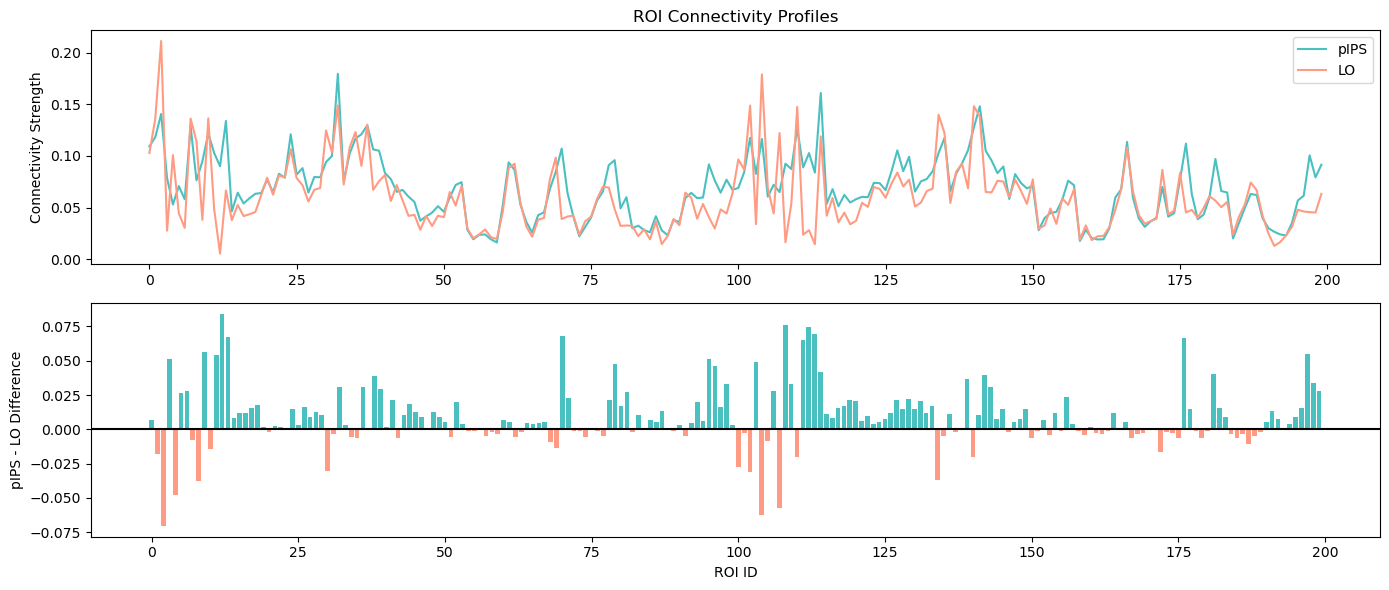

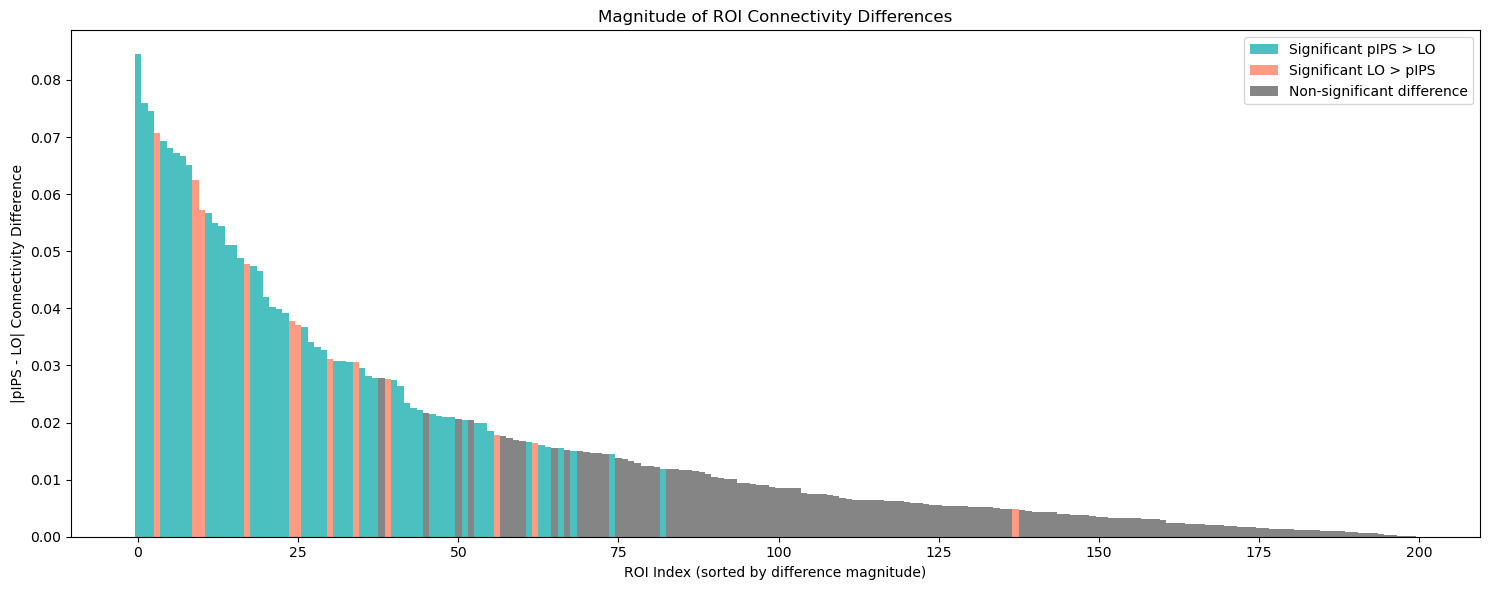

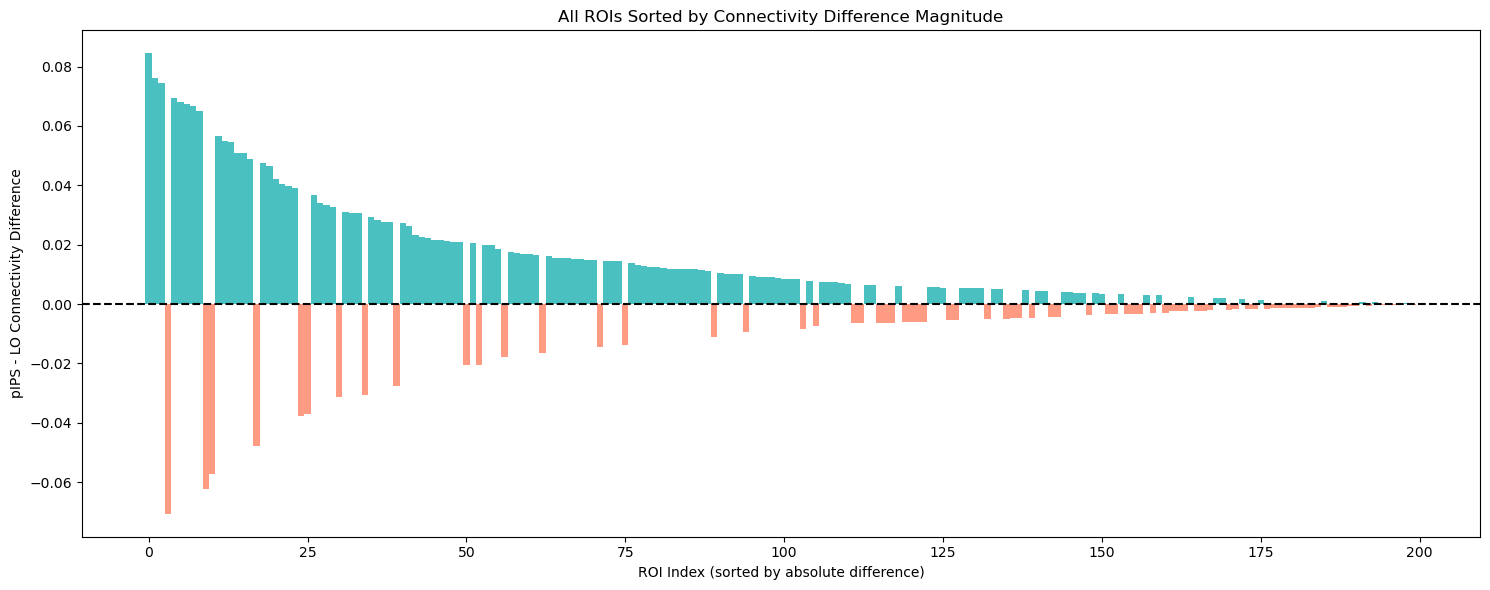

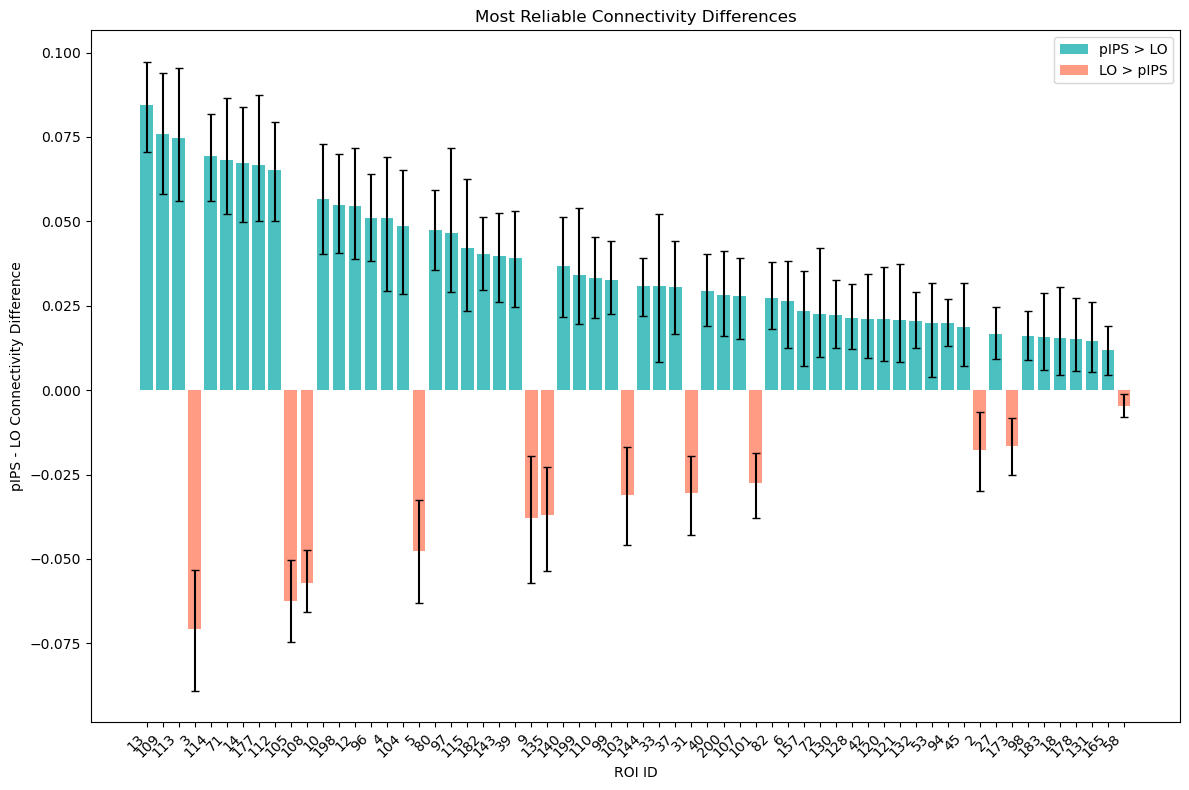

In [ ]:
#Fingerprint Connectivity
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, datasets, plotting
from nilearn.maskers import NiftiLabelsMasker
from scipy import stats
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection

# Define paths for your data
study_dir = "/lab_data/behrmannlab/vlad/ptoc"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
sub_info_path = '/user_data/csimmon2/git_repos/ptoc/sub_info.csv'
output_dir = f'{results_dir}/connectivity_comparison'
os.makedirs(output_dir, exist_ok=True)

# Load Schaefer atlas for reference
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
atlas_img = nib.load(atlas.maps)
atlas_labels = atlas.labels

def get_roi_name(roi_id):
    """Get the full name of an ROI from its ID"""
    try:
        idx = int(roi_id) - 1
        if 0 <= idx < len(atlas_labels):
            label = atlas_labels[idx]
            if isinstance(label, bytes):
                label = label.decode('utf-8')
            return label
    except:
        pass
    return f"ROI_{roi_id}"

def analyze_aggregated_bilateral_connectivity(run_bootstrap=True, run_loocv=True, run_permutation=False, n_perms=10000):
    """Analyze connectivity fingerprints with combined bilateral seeds"""
    print("Analyzing aggregated bilateral connectivity for pIPS and LO regions...")
    
    # Load subject info
    sub_info = pd.read_csv(sub_info_path)
    subjects = sub_info[sub_info['group'] == 'control']['sub'].tolist()
    print(f"Found {len(subjects)} control subjects")
    
    # Define ROIs and hemispheres
    rois = ['pIPS', 'LO']
    hemispheres = ['left', 'right']
    analysis_type = 'fc'
    
    # Setup atlas masker
    masker = NiftiLabelsMasker(labels_img=atlas_img, standardize=False)
    
    # Load and process subject data
    subject_data = []
    for sub in subjects:
        sub_conn = {}
        
        for roi in rois:
            # Initialize arrays to hold combined data
            combined_data = None
            hemi_count = 0
            
            for hemisphere in hemispheres:
                fc_file = f'{study_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_{roi}_{hemisphere}_loc_{analysis_type}_mni.nii.gz'
                
                if os.path.exists(fc_file):
                    try:
                        # Load the FC map
                        fc_img = nib.load(fc_file)
                        
                        # Extract ROI values using atlas
                        fc_values = masker.fit_transform(fc_img)[0]
                        
                        # Add to combined data
                        if combined_data is None:
                            combined_data = fc_values
                        else:
                            combined_data += fc_values
                        
                        hemi_count += 1
                    except Exception as e:
                        print(f"Error processing {fc_file}: {e}")
            
            # Average the data if we have at least one hemisphere
            if hemi_count > 0:
                sub_conn[roi] = combined_data / hemi_count
        
        # Only include subjects with both ROIs
        if len(sub_conn) == len(rois):
            subject_data.append(sub_conn)
    
    n_valid_subjects = len(subject_data)
    print(f"Successfully loaded data for {n_valid_subjects} subjects")
    
    if n_valid_subjects < 3:
        print("Not enough valid subjects. Analysis cannot proceed.")
        return None
    
    # Initialize arrays for analysis
    n_rois = len(atlas_labels)
    pips_fc = np.zeros((n_valid_subjects, n_rois))
    lo_fc = np.zeros((n_valid_subjects, n_rois))
    
    # Fill arrays with connectivity data
    for i, subj_data in enumerate(subject_data):
        pips_fc[i, :] = subj_data['pIPS']
        lo_fc[i, :] = subj_data['LO']
    
    # Calculate connectivity vector correlation for each subject
    vector_correlations = np.zeros(n_valid_subjects)
    for i in range(n_valid_subjects):
        vector_correlations[i] = np.corrcoef(pips_fc[i, :], lo_fc[i, :])[0, 1]
    
    print(f"Mean connectivity vector correlation: {np.mean(vector_correlations):.3f} ± {np.std(vector_correlations):.3f}")
    
    # Calculate mean connectivity profiles
    mean_pips = np.mean(pips_fc, axis=0)
    mean_lo = np.mean(lo_fc, axis=0)
    
    # Calculate difference profile
    diff_profile = mean_pips - mean_lo
    abs_diff_profile = np.abs(diff_profile)
    
    # Initialize variables for statistical testing
    sig_boot = np.zeros(n_rois, dtype=bool)
    ci_lower = np.zeros(n_rois)
    ci_upper = np.zeros(n_rois)
    sig_perm = np.zeros(n_rois, dtype=bool)
    perm_pvals = np.ones(n_rois)
    sig_loo = np.zeros(n_rois, dtype=bool)
    loo_reliability = np.zeros(n_rois)
    
    # 1. Bootstrap analysis for robust differences
    if run_bootstrap:
        print("Performing bootstrap analysis...")
        n_boots = 100000
        boot_diffs = np.zeros((n_boots, n_rois))
        
        for i in range(n_boots):
            # Resample subjects with replacement
            boot_idx = resample(range(n_valid_subjects), replace=True, n_samples=n_valid_subjects)
            
            # Calculate mean difference for this bootstrap sample
            boot_pips = np.mean(pips_fc[boot_idx, :], axis=0)
            boot_lo = np.mean(lo_fc[boot_idx, :], axis=0)
            boot_diffs[i, :] = boot_pips - boot_lo
        
        # Calculate confidence intervals
        ci_lower = np.percentile(boot_diffs, 2.5, axis=0)
        ci_upper = np.percentile(boot_diffs, 97.5, axis=0)
        
        # Identify significant differences (95% CI doesn't cross zero)
        sig_boot = (ci_lower > 0) | (ci_upper < 0)
        sig_boot_count = np.sum(sig_boot)
        print(f"Found {sig_boot_count} ROIs with significant differences via bootstrap")
    
    # 2. Permutation testing for exact p-values
    if run_permutation:
        print(f"Performing permutation testing with {n_perms} permutations...")
        # Calculate observed differences
        observed_diffs = diff_profile
        
        # Initialize array to store permutation results
        perm_diffs = np.zeros((n_perms, n_rois))
        
        # Perform permutations
        for i in range(n_perms):
            # For each subject, randomly swap pIPS and LO connectivity values
            perm_pips = np.zeros_like(pips_fc)
            perm_lo = np.zeros_like(lo_fc)
            
            for s in range(n_valid_subjects):
                if np.random.rand() > 0.5:
                    perm_pips[s, :] = pips_fc[s, :]
                    perm_lo[s, :] = lo_fc[s, :]
                else:
                    perm_pips[s, :] = lo_fc[s, :]
                    perm_lo[s, :] = pips_fc[s, :]
            
            # Calculate permuted difference
            perm_diffs[i, :] = np.mean(perm_pips - perm_lo, axis=0)
        
        # Calculate two-tailed p-values
        perm_pvals = np.zeros(n_rois)
        for r in range(n_rois):
            if observed_diffs[r] >= 0:
                perm_pvals[r] = np.mean(perm_diffs[:, r] >= observed_diffs[r])
            else:
                perm_pvals[r] = np.mean(perm_diffs[:, r] <= observed_diffs[r])
        
        # Double for two-tailed test
        perm_pvals = np.minimum(perm_pvals * 2, 1.0)
        
        # Apply FDR correction
        _, perm_pvals_fdr = fdrcorrection(perm_pvals, alpha=0.05)
        
        # Identify significant differences
        sig_perm = perm_pvals_fdr < 0.05
        sig_perm_count = np.sum(sig_perm)
        print(f"Found {sig_perm_count} ROIs with significant differences via permutation testing (FDR-corrected)")
    
    # 3. Leave-One-Out Cross-Validation for reliability
    if run_loocv:
        print("Performing Leave-One-Out Cross-Validation...")
        loo_reliability = np.zeros(n_rois)
        
        for left_out in range(n_valid_subjects):
            # Create the training set (all subjects except the left out one)
            train_idx = list(range(n_valid_subjects))
            train_idx.remove(left_out)
            
            # Calculate mean training differences
            train_diff = np.mean(pips_fc[train_idx, :] - lo_fc[train_idx, :], axis=0)
            
            # Test on left out subject
            test_diff = pips_fc[left_out, :] - lo_fc[left_out, :]
            
            # Calculate consistency of signs between training and test
            loo_reliability += (np.sign(train_diff) == np.sign(test_diff)).astype(float)
        
        # Convert to proportion of consistent predictions
        loo_reliability = loo_reliability / n_valid_subjects
        
        # Set threshold at 75% consistency
        loo_threshold = 0.75
        sig_loo = loo_reliability >= loo_threshold
        sig_loo_count = np.sum(sig_loo)
        
        print(f"LOO reliability threshold: {loo_threshold:.3f}")
        print(f"Found {sig_loo_count} ROIs with high reliability via LOO")
    
    # Combine significance based on which tests are run
    sig_combined = np.zeros(n_rois, dtype=bool)
    
    if run_bootstrap and not run_permutation and not run_loocv:
        sig_combined = sig_boot
    elif run_bootstrap and run_permutation and not run_loocv:
        sig_combined = sig_boot & sig_perm
    elif run_bootstrap and run_loocv and not run_permutation:
        sig_combined = sig_boot & sig_loo
    elif run_permutation and run_loocv and not run_bootstrap:
        sig_combined = sig_perm & sig_loo
    elif run_bootstrap and run_permutation and run_loocv:
        sig_combined = (sig_boot & sig_perm) | (sig_boot & sig_loo) | (sig_perm & sig_loo)
    elif run_permutation and not run_bootstrap and not run_loocv:
        sig_combined = sig_perm
    elif run_loocv and not run_bootstrap and not run_permutation:
        sig_combined = sig_loo
    
    sig_combined_count = np.sum(sig_combined)
    print(f"Found {sig_combined_count} ROIs significant with combined criteria")
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'ROI_ID': np.arange(1, n_rois + 1),
        'pIPS_Connectivity': mean_pips,
        'LO_Connectivity': mean_lo,
        'Difference': diff_profile,
        'Abs_Difference': abs_diff_profile,
        'CI_Lower': ci_lower,
        'CI_Upper': ci_upper
    })
    
    # Add statistical test results if run
    if run_bootstrap:
        results_df['Bootstrap_Significant'] = sig_boot
    if run_permutation:
        results_df['Permutation_PValue'] = perm_pvals
        results_df['Permutation_Significant'] = sig_perm
    if run_loocv:
        results_df['LOO_Reliability'] = loo_reliability
        results_df['LOO_Significant'] = sig_loo
    
    results_df['Combined_Significant'] = sig_combined
    
    # Add ROI names
    results_df['ROI_Name'] = results_df['ROI_ID'].apply(get_roi_name)
    
    # Identify ROI direction (pIPS>LO or LO>pIPS)
    results_df['Direction'] = np.where(results_df['Difference'] > 0, 'pIPS > LO', 'LO > pIPS')
    
    # Visualize connectivity profiles
    plt.figure(figsize=(14, 6))
    plt.subplot(2, 1, 1)
    x = np.arange(n_rois)
    plt.plot(x, mean_pips, color='#4ac0c0', linestyle='-', label='pIPS')  # Teal for pIPS
    plt.plot(x, mean_lo, color='#ff9b83', linestyle='-', label='LO')      # Peach for LO
    plt.ylabel('Connectivity Strength')
    plt.title('ROI Connectivity Profiles')
    plt.legend()

    plt.subplot(2, 1, 2)
    colors = ['#4ac0c0' if val > 0 else '#ff9b83' for val in diff_profile]  # Teal for pIPS>LO, Peach for LO>pIPS
    plt.bar(x, diff_profile, color=colors)
    plt.axhline(y=0, color='black', linestyle='-')
    plt.ylabel('pIPS - LO Difference')
    plt.xlabel('ROI ID')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/bilateral_connectivity_profiles.png', dpi=300)
    
    # Create figure showing all ROIs sorted by absolute difference
    plt.figure(figsize=(15, 6))
    sorted_idx = np.argsort(abs_diff_profile)[::-1]  # Sort by absolute difference

    # Colorblind-friendly palette
    # - teal: significant pIPS > LO
    # - peach: significant LO > pIPS 
    # - Gray: not significant
    colors = []
    for i in sorted_idx:
        if sig_combined[i]:
            if diff_profile[i] > 0:
                colors.append('#4ac0c0')  # Teal for pIPS
            else:
                colors.append('#ff9b83')  # Peach for LO
        else:
            colors.append('#858585')      # Gray

    # Plot bars all pointing upward
    plt.bar(range(len(sorted_idx)), abs_diff_profile[sorted_idx], color=colors, width=1.0)

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#4ac0c0', label='Significant pIPS > LO'),
        Patch(facecolor='#ff9b83', label='Significant LO > pIPS'),
        Patch(facecolor='#858585', label='Non-significant difference')
    ]
    plt.legend(handles=legend_elements)

    plt.xlabel('ROI Index (sorted by difference magnitude)')
    plt.ylabel('|pIPS - LO| Connectivity Difference')
    plt.title('Magnitude of ROI Connectivity Differences')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/all_connectivity_differences_magnitude.png', dpi=300)

    # Create figure showing all ROIs sorted by absolute difference
    plt.figure(figsize=(15, 6))
    sorted_idx = np.argsort(abs_diff_profile)[::-1]  # Sort by absolute difference

    # Plot bars with color coding
    plt.bar(range(len(sorted_idx)), diff_profile[sorted_idx], 
        color=['#4ac0c0' if diff > 0 else '#ff9b83' for diff in diff_profile[sorted_idx]], 
        width=1.0)

    plt.axhline(y=0, color='black', linestyle='--')
    plt.xlabel('ROI Index (sorted by absolute difference)')
    plt.ylabel('pIPS - LO Connectivity Difference')
    plt.title('All ROIs Sorted by Connectivity Difference Magnitude')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/all_connectivity_differences_sorted.png', dpi=300)
    
    # Visualize top reliable differences
    top_rois = results_df[results_df['Combined_Significant']].sort_values('Abs_Difference', ascending=False)
    
    if len(top_rois) > 0:
        plt.figure(figsize=(12, 8))
        x = np.arange(len(top_rois))
        
        # Color by direction
        colors = np.where(top_rois['Difference'] > 0, '#4ac0c0', '#ff9b83')  # Teal for pIPS>LO, Peach for LO>pIPS
        
        plt.bar(x, top_rois['Difference'], color=colors)
        plt.errorbar(x, top_rois['Difference'], 
                     yerr=[top_rois['Difference'] - top_rois['CI_Lower'], 
                           top_rois['CI_Upper'] - top_rois['Difference']], 
                     fmt='none', color='black', capsize=3)
        
        # Add ROI labels
        plt.xticks(x, [f"{row['ROI_ID']}" for _, row in top_rois.iterrows()], rotation=45, ha='right')
        
        plt.xlabel('ROI ID')
        plt.ylabel('pIPS - LO Connectivity Difference')
        plt.title('Most Reliable Connectivity Differences')
        
        # Add a legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#4ac0c0', label='pIPS > LO'),  # Teal for pIPS>LO
            Patch(facecolor='#ff9b83', label='LO > pIPS')    # Peach for LO>pIPS
        ]
        plt.legend(handles=legend_elements)
        
        plt.tight_layout()
        plt.savefig(f'{output_dir}/bilateral_reliable_differences.png', dpi=300)
    
    # Save results to CSV
    results_df.to_csv(f'{output_dir}/bilateral_connectivity_fingerprint_results.csv', index=False)
    
    # Print top ROIs
    if len(top_rois) > 0:
        print("\nTop most reliable bilateral connectivity differences:")
        for i, (_, row) in enumerate(top_rois.head(15).iterrows()):
            print(f"{i+1}. ROI_{row['ROI_ID']} ({row['ROI_Name']}): " +
                  f"Diff = {row['Difference']:.3f} [{row['CI_Lower']:.3f}, {row['CI_Upper']:.3f}], " +
                  f"Direction: {row['Direction']}")
    
    # Prepare return dictionary
    result_dict = {
        'results': results_df,
        'vector_correlations': vector_correlations
    }
    
    # Add test results if run
    if run_bootstrap:
        result_dict['bootstrap_sig_count'] = np.sum(sig_boot)
    if run_permutation:
        result_dict['perm_sig_count'] = np.sum(sig_perm)
    if run_loocv:
        result_dict['loo_sig_count'] = np.sum(sig_loo)
    
    result_dict['combined_sig_count'] = sig_combined_count
    
    return result_dict

# Run the analysis with chosen methods
results = analyze_aggregated_bilateral_connectivity(run_bootstrap=True, run_loocv=True, run_permutation=False)

Analyzing asymmetry in connections between pIPS and LO...
Loaded connectivity data with 200 ROIs
Found 62 significant ROIs
pIPS > LO: 50 regions
LO > pIPS: 12 regions

Chi-square test for asymmetry in number of connections:
Observed frequencies: pIPS > LO: 50, LO > pIPS: 12
Expected frequencies: pIPS > LO: 31.0, LO > pIPS: 31.0
Chi-square statistic: 23.2903
p-value: 0.00000139
The asymmetry in number of connections is statistically significant.
pIPS has significantly more connections than LO (p < .001).

Mean strength of pIPS-dominant connections: 0.0370 ± 0.0192
Mean strength of LO-dominant connections: 0.0368 ± 0.0189

Mann-Whitney U test for connection strength differences:
U statistic: 291.0
p-value: 0.87962230
No significant difference in connection strength between pIPS-dominant and LO-dominant regions.

Total connectivity strength:
pIPS: 1.8486 (across 50 connections)
LO: 0.4412 (across 12 connections)
Ratio pIPS/LO: 4.19

Analysis complete. Results saved to /user_data/csimmon2/

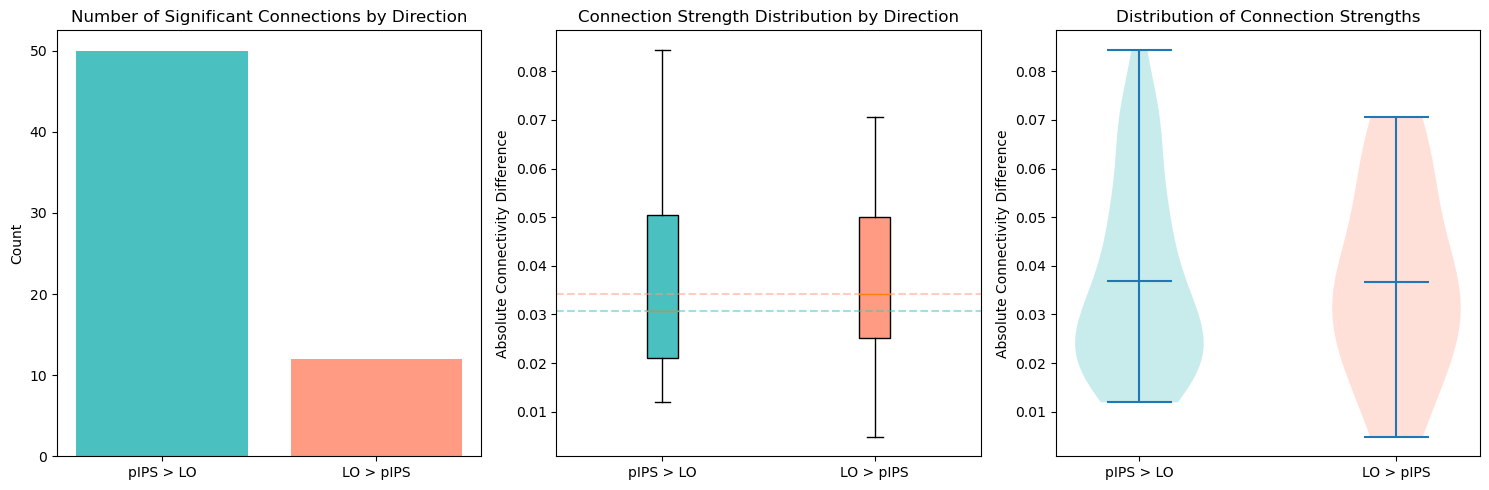

In [ ]:
# Chi-square comparison of pIPS>LO connectivities
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

def analyze_connectivity_asymmetry():
    """
    Analyze the asymmetry in number and strength of connections for pIPS and LO regions.
    Tests whether pIPS has significantly more and stronger connections than LO.
    Uses Mann-Whitney U test for strength comparison to handle unequal sample sizes.
    """
    import os
    import numpy as np
    import pandas as pd
    from scipy import stats
    import matplotlib.pyplot as plt
    
    # Define paths
    results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
    connectivity_dir = f'{results_dir}/connectivity_comparison'
    output_dir = f'{results_dir}/connectivity_asymmetry'
    os.makedirs(output_dir, exist_ok=True)
    
    print("Analyzing asymmetry in connections between pIPS and LO...")
    
    # Load connectivity results
    results_path = f'{connectivity_dir}/bilateral_connectivity_fingerprint_results.csv'
    if not os.path.exists(results_path):
        print(f"Error: Could not find connectivity results at {results_path}")
        return None
    
    results_df = pd.read_csv(results_path)
    print(f"Loaded connectivity data with {len(results_df)} ROIs")
    
    # Filter to significant regions according to the combined criteria
    sig_regions = results_df[results_df['Combined_Significant'] == True]
    print(f"Found {len(sig_regions)} significant ROIs")
    
    # Count regions by direction
    pips_stronger_count = sum(sig_regions['Direction'] == 'pIPS > LO')
    lo_stronger_count = sum(sig_regions['Direction'] == 'LO > pIPS')
    
    print(f"pIPS > LO: {pips_stronger_count} regions")
    print(f"LO > pIPS: {lo_stronger_count} regions")
    
    # 1. Chi-square test for number of connections
    observed = np.array([pips_stronger_count, lo_stronger_count])
    expected = np.array([observed.sum()/2, observed.sum()/2])  # Expected under null hypothesis of equal distribution
    
    chi2, p_value = stats.chisquare(observed, expected)
    
    print("\nChi-square test for asymmetry in number of connections:")
    print(f"Observed frequencies: pIPS > LO: {observed[0]}, LO > pIPS: {observed[1]}")
    print(f"Expected frequencies: pIPS > LO: {expected[0]}, LO > pIPS: {expected[1]}")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"p-value: {p_value:.8f}")
    
    if p_value < 0.05:
        print("The asymmetry in number of connections is statistically significant.")
        if pips_stronger_count > lo_stronger_count:
            print(f"pIPS has significantly more connections than LO (p {'< .001' if p_value < 0.001 else f'= {p_value:.4f}'}).")
        else:
            print(f"LO has significantly more connections than pIPS (p {'< .001' if p_value < 0.001 else f'= {p_value:.4f}'}).")
    else:
        print("The asymmetry in number of connections is not statistically significant.")
    
    # 2. Extract connectivity strength values for significant regions
    pips_stronger = np.abs(sig_regions[sig_regions['Direction'] == 'pIPS > LO']['Difference'].values)
    lo_stronger = np.abs(sig_regions[sig_regions['Direction'] == 'LO > pIPS']['Difference'].values)
    
    print(f"\nMean strength of pIPS-dominant connections: {np.mean(pips_stronger):.4f} ± {np.std(pips_stronger):.4f}")
    print(f"Mean strength of LO-dominant connections: {np.mean(lo_stronger):.4f} ± {np.std(lo_stronger):.4f}")
    
    # Mann-Whitney U test for comparing strength distributions (better for unequal sample sizes)
    if len(pips_stronger) > 0 and len(lo_stronger) > 0:
        u_stat, p_value_mw = stats.mannwhitneyu(pips_stronger, lo_stronger, alternative='two-sided')
        
        print("\nMann-Whitney U test for connection strength differences:")
        print(f"U statistic: {u_stat}")
        print(f"p-value: {p_value_mw:.8f}")
        
        if p_value_mw < 0.05:
            if np.median(pips_stronger) > np.median(lo_stronger):
                print(f"pIPS-dominant connections are significantly stronger than LO-dominant connections (p {'< .001' if p_value_mw < 0.001 else f'= {p_value_mw:.4f}'}).")
            else:
                print(f"LO-dominant connections are significantly stronger than pIPS-dominant connections (p {'< .001' if p_value_mw < 0.001 else f'= {p_value_mw:.4f}'}).")
        else:
            print("No significant difference in connection strength between pIPS-dominant and LO-dominant regions.")
        
        # Also calculate total connectivity strength
        pips_total = np.sum(pips_stronger)
        lo_total = np.sum(lo_stronger)
        print("\nTotal connectivity strength:")
        print(f"pIPS: {pips_total:.4f} (across {len(pips_stronger)} connections)")
        print(f"LO: {lo_total:.4f} (across {len(lo_stronger)} connections)")
        print(f"Ratio pIPS/LO: {pips_total/lo_total:.2f}")
    else:
        print("Cannot perform strength comparison: insufficient data in one or both groups.")
    
    # 3. Create visualizations
    plt.figure(figsize=(15, 5))
    
    # Plot number of connections
    plt.subplot(1, 3, 1)
    plt.bar(['pIPS > LO', 'LO > pIPS'], [pips_stronger_count, lo_stronger_count], 
            color=['#4ac0c0', '#ff9b83'])  # Using the same colors as in the original script
    plt.title('Number of Significant Connections by Direction')
    plt.ylabel('Count')
    
    # Plot connection strengths with boxplot
    if len(pips_stronger) > 0 and len(lo_stronger) > 0:
        plt.subplot(1, 3, 2)
        boxplot = plt.boxplot([pips_stronger, lo_stronger], labels=['pIPS > LO', 'LO > pIPS'], 
                  patch_artist=True)
        
        # Set colors to match the bar plot
        boxplot['boxes'][0].set_facecolor('#4ac0c0')
        boxplot['boxes'][1].set_facecolor('#ff9b83')
        
        plt.title('Connection Strength Distribution by Direction')
        plt.ylabel('Absolute Connectivity Difference')
        
        # Add median lines to the plot
        plt.axhline(y=np.median(pips_stronger), color='#4ac0c0', linestyle='--', alpha=0.5)
        plt.axhline(y=np.median(lo_stronger), color='#ff9b83', linestyle='--', alpha=0.5)
        
        # Plot violin plot to better visualize distributions
        plt.subplot(1, 3, 3)
        violin = plt.violinplot([pips_stronger, lo_stronger], showmeans=True)
        
        # Customize violin plot colors
        for i, pc in enumerate(violin['bodies']):
            if i == 0:
                pc.set_facecolor('#4ac0c0')
            else:
                pc.set_facecolor('#ff9b83')
        
        plt.xticks([1, 2], ['pIPS > LO', 'LO > pIPS'])
        plt.title('Distribution of Connection Strengths')
        plt.ylabel('Absolute Connectivity Difference')
    
    plt.tight_layout()
    #plt.savefig(f'{output_dir}/connectivity_asymmetry_analysis.png', dpi=300)
    #plt.close()
    
    print(f"\nAnalysis complete. Results saved to {output_dir}")
    
    return {
        'number_test': {'chi2': chi2, 'p_value': p_value},
        'strength_test': {'u_stat': u_stat if 'u_stat' in locals() else None, 
                          'p_value': p_value_mw if 'p_value_mw' in locals() else None},
        'counts': {'pips_stronger': pips_stronger_count, 'lo_stronger': lo_stronger_count},
        'strengths': {'pips_mean': np.mean(pips_stronger) if len(pips_stronger) > 0 else None,
                      'lo_mean': np.mean(lo_stronger) if len(lo_stronger) > 0 else None,
                      'pips_median': np.median(pips_stronger) if len(pips_stronger) > 0 else None,
                      'lo_median': np.median(lo_stronger) if len(lo_stronger) > 0 else None,
                      'pips_total': np.sum(pips_stronger) if len(pips_stronger) > 0 else None,
                      'lo_total': np.sum(lo_stronger) if len(lo_stronger) > 0 else None}
    }

# Run the analysis
if __name__ == "__main__":
    results = analyze_connectivity_asymmetry()

Running connectivity analysis...
Analysis complete. Found 62 significant ROIs
Creating visualizations...
Visualizations saved to /user_data/csimmon2/git_repos/ptoc/results/connectivity_analysis/visualizations
Pipeline completed successfully!


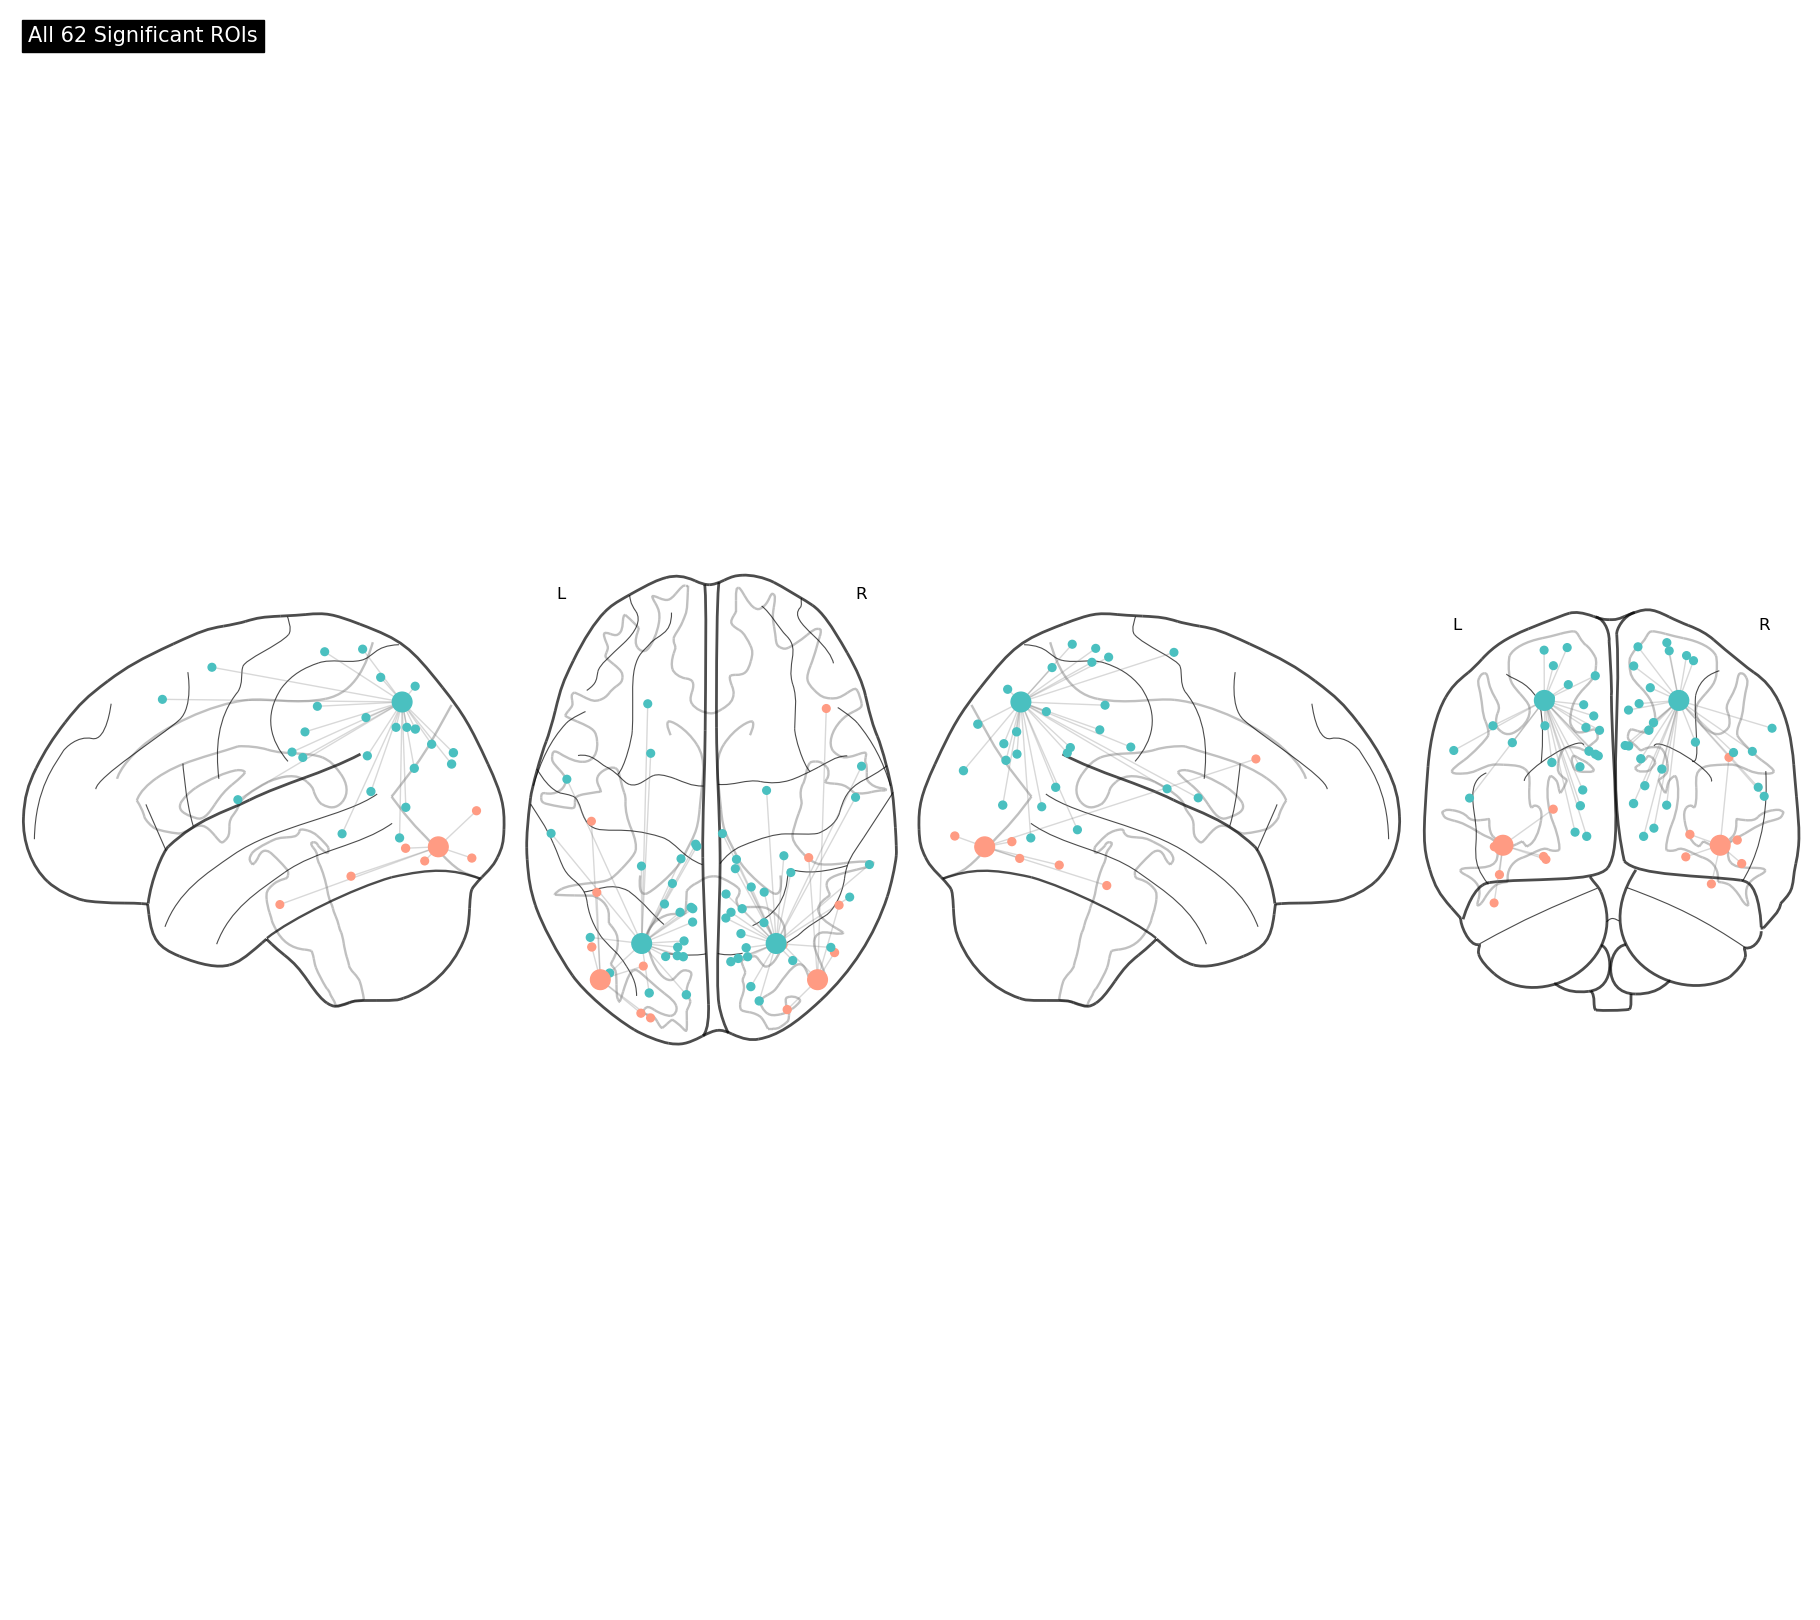

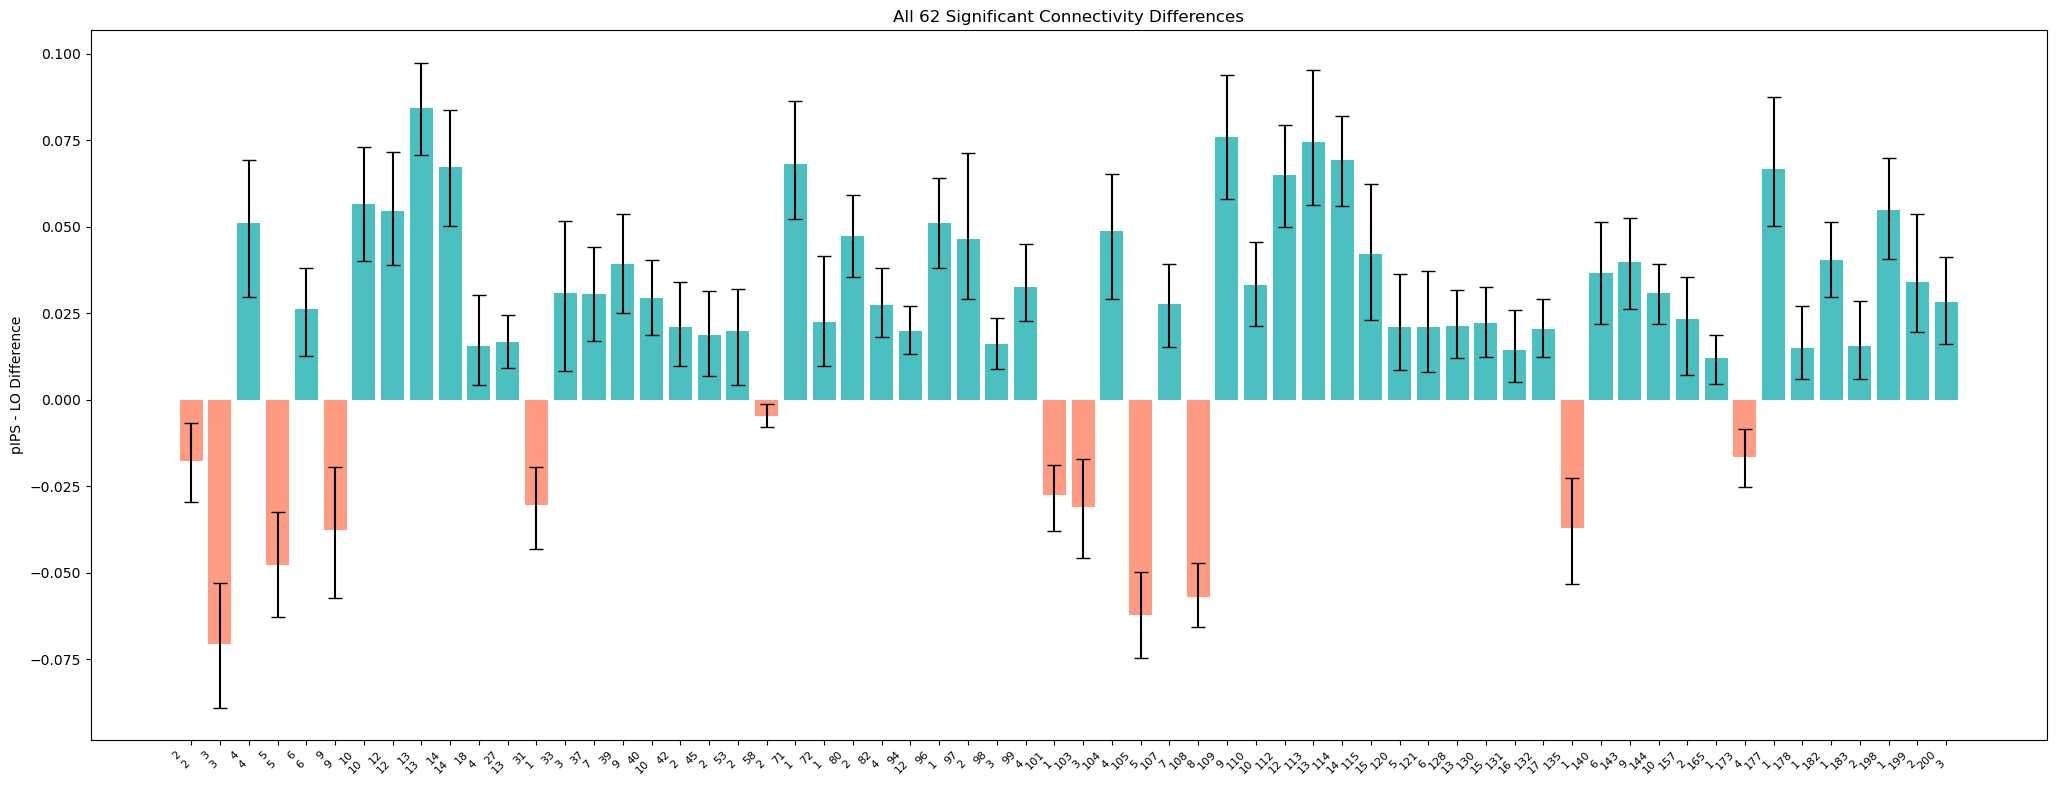

In [ ]:
# Brain Connectivity Figure 
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import plotting, datasets, image
from nilearn.maskers import NiftiLabelsMasker
from scipy import stats
from sklearn.utils import resample
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ========================
# 1. SETUP AND PATHS
# ========================
study_dir = "/lab_data/behrmannlab/vlad/ptoc"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
sub_info_path = '/user_data/csimmon2/git_repos/ptoc/sub_info.csv'
output_dir = f'{results_dir}/connectivity_analysis'
vis_dir = f'{output_dir}/visualizations'
os.makedirs(vis_dir, exist_ok=True)

# ========================
# 2. ANALYSIS FUNCTION
# ========================
def run_connectivity_analysis():
    """Run full connectivity analysis and return results with significant ROIs"""
    print("Running connectivity analysis...")
    
    # Load atlas and subjects
    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
    atlas_img = nib.load(atlas.maps)
    sub_info = pd.read_csv(sub_info_path)
    subjects = sub_info[sub_info['group'] == 'control']['sub'].tolist()
    
    # Initialize data storage
    masker = NiftiLabelsMasker(labels_img=atlas_img, standardize=False)
    subject_data = []
    
    # Process each subject
    for sub in subjects:
        sub_conn = {}
        for roi in ['pIPS', 'LO']:
            combined_data, hemi_count = None, 0
            for hem in ['left', 'right']:
                fc_file = f'{study_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_{roi}_{hem}_loc_fc_mni.nii.gz'
                if os.path.exists(fc_file):
                    try:
                        fc_data = masker.fit_transform(nib.load(fc_file))[0]
                        combined_data = fc_data if combined_data is None else combined_data + fc_data
                        hemi_count += 1
                    except Exception as e:
                        print(f"Error processing {fc_file}: {e}")
            if hemi_count > 0:
                sub_conn[roi] = combined_data / hemi_count
        
        if len(sub_conn) == 2:
            subject_data.append(sub_conn)
    
    # Create group matrices
    pips_fc = np.array([s['pIPS'] for s in subject_data])
    lo_fc = np.array([s['LO'] for s in subject_data])
    
    # Calculate group differences
    mean_pips = np.mean(pips_fc, axis=0)
    mean_lo = np.mean(lo_fc, axis=0)
    diff = mean_pips - mean_lo
    abs_diff = np.abs(diff)
    
    # Bootstrap analysis
    n_boots = 10000
    boot_diffs = np.zeros((n_boots, 200))
    for i in range(n_boots):
        idx = resample(range(len(subject_data)), replace=True)
        boot_diffs[i] = np.mean(pips_fc[idx] - lo_fc[idx], axis=0)
    
    ci_lower = np.percentile(boot_diffs, 2.5, axis=0)
    ci_upper = np.percentile(boot_diffs, 97.5, axis=0)
    sig_boot = (ci_lower > 0) | (ci_upper < 0)
    
    # Leave-One-Out reliability
    loo_reliability = np.zeros(200)
    for left_out in range(len(subject_data)):
        train_diff = np.mean(np.delete(pips_fc, left_out, axis=0) - np.delete(lo_fc, left_out, axis=0), axis=0)
        test_diff = pips_fc[left_out] - lo_fc[left_out]
        loo_reliability += (np.sign(train_diff) == np.sign(test_diff)).astype(float)
    loo_reliability /= len(subject_data)
    sig_loo = loo_reliability >= 0.75
    
    # Combined significance
    sig_combined = sig_boot & sig_loo
    sig_roi_ids = np.where(sig_combined)[0] + 1  # ROI IDs start at 1
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'ROI_ID': range(1, 201),
        'ROI_Name': [atlas.labels[i-1].decode('utf-8') if isinstance(atlas.labels[i-1], bytes) 
                    else atlas.labels[i-1] for i in range(1, 201)],
        'Difference': diff,
        'CI_Lower': ci_lower,
        'CI_Upper': ci_upper,
        'LOO_Reliability': loo_reliability,
        'Combined_Significant': sig_combined
    })
    
    print(f"Analysis complete. Found {len(sig_roi_ids)} significant ROIs")
    return results_df, sig_roi_ids

# ========================
# 3. VISUALIZATION FUNCTION
# ========================
def visualize_results(results_df, sig_roi_ids):
    """Create visualizations for significant ROIs"""
    print("Creating visualizations...")
    
    # Filter significant ROIs
    sig_df = results_df[results_df['ROI_ID'].isin(sig_roi_ids)].copy()
    sig_df['Hemisphere'] = sig_df['ROI_Name'].apply(lambda x: 'L' if 'LH' in x else 'R')
    
    # Load atlas
    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
    atlas_img = nib.load(atlas.maps)
    
    # Get coordinates for all ROIs
    all_coords = plotting.find_parcellation_cut_coords(atlas_img)
    
    # Prepare node properties
    sig_coords = []
    sig_colors = []
    sig_sizes = []
    sig_labels = []
    
    for _, row in sig_df.iterrows():
        roi_idx = row['ROI_ID'] - 1  # Convert to 0-based index
        sig_coords.append(all_coords[roi_idx])
        sig_colors.append('#4ac0c0' if row['Difference'] > 0 else '#ff9b83')
        sig_sizes.append(abs(row['Difference']) * 40 + 30)
        sig_labels.append(f"{row['ROI_ID']}\n{row['ROI_Name'].split('_')[-1]}")
    
    # Add seed nodes
    seed_coords = [
        [-26, -68, 48], [26, -68, 48],  # pIPS L/R
        [-42, -82, -8], [42, -82, -8]    # LO L/R
    ]
    all_coords = sig_coords + seed_coords
    all_colors = sig_colors + ['#4ac0c0', '#4ac0c0', '#ff9b83', '#ff9b83']
    all_sizes = sig_sizes + [200, 200, 200, 200]
    
    # Create adjacency matrix
    adjacency = np.zeros((len(all_coords), len(all_coords)))
    for i, row in enumerate(sig_df.itertuples()):
        tgt_offset = 0 if row.Difference > 0 else 2
        tgt_idx = len(sig_coords) + tgt_offset + (0 if row.Hemisphere == 'L' else 1)
        adjacency[i, tgt_idx] = adjacency[tgt_idx, i] = 1
    
    # Create network plot
    fig = plt.figure(figsize=(18, 16))
    plotting.plot_connectome(
        adjacency, all_coords,
        node_color=all_colors,
        node_size=all_sizes,
        edge_kwargs={'color': 'gray', 'alpha': 0.3, 'linewidth': 1.0},
        display_mode='lzry',
        title=f'All {len(sig_df)} Significant ROIs',
        figure=fig
    )
    plt.savefig(f'{vis_dir}/network_all_significant.png', dpi=300)
    
    # Create bar plot
    plt.figure(figsize=(max(14, len(sig_df)/3), 8))
    plt.bar(range(len(sig_df)), sig_df['Difference'],
            color=['#4ac0c0' if x > 0 else '#ff9b83' for x in sig_df['Difference']])
    plt.errorbar(range(len(sig_df)), sig_df['Difference'],
                 yerr=[sig_df['Difference']-sig_df['CI_Lower'], 
                       sig_df['CI_Upper']-sig_df['Difference']],
                 fmt='none', color='black', capsize=5)
    plt.xticks(range(len(sig_df)), sig_labels, rotation=45, ha='right', fontsize=8)
    plt.ylabel('pIPS - LO Difference')
    plt.title(f'All {len(sig_df)} Significant Connectivity Differences')
    plt.tight_layout()
    plt.savefig(f'{vis_dir}/differences_all_significant.png', dpi=300)
    
    print(f"Visualizations saved to {vis_dir}")


# ========================
# 4. RUN THE FULL PIPELINE
# ========================
if __name__ == "__main__":
    # Run analysis and get results
    results_df, sig_roi_ids = run_connectivity_analysis()
    
    # Save full results
    results_df.to_csv(f'{output_dir}/connectivity_results_full.csv', index=False)
    
    # Create visualizations
    visualize_results(results_df, sig_roi_ids)
    
    print("Pipeline completed successfully!")

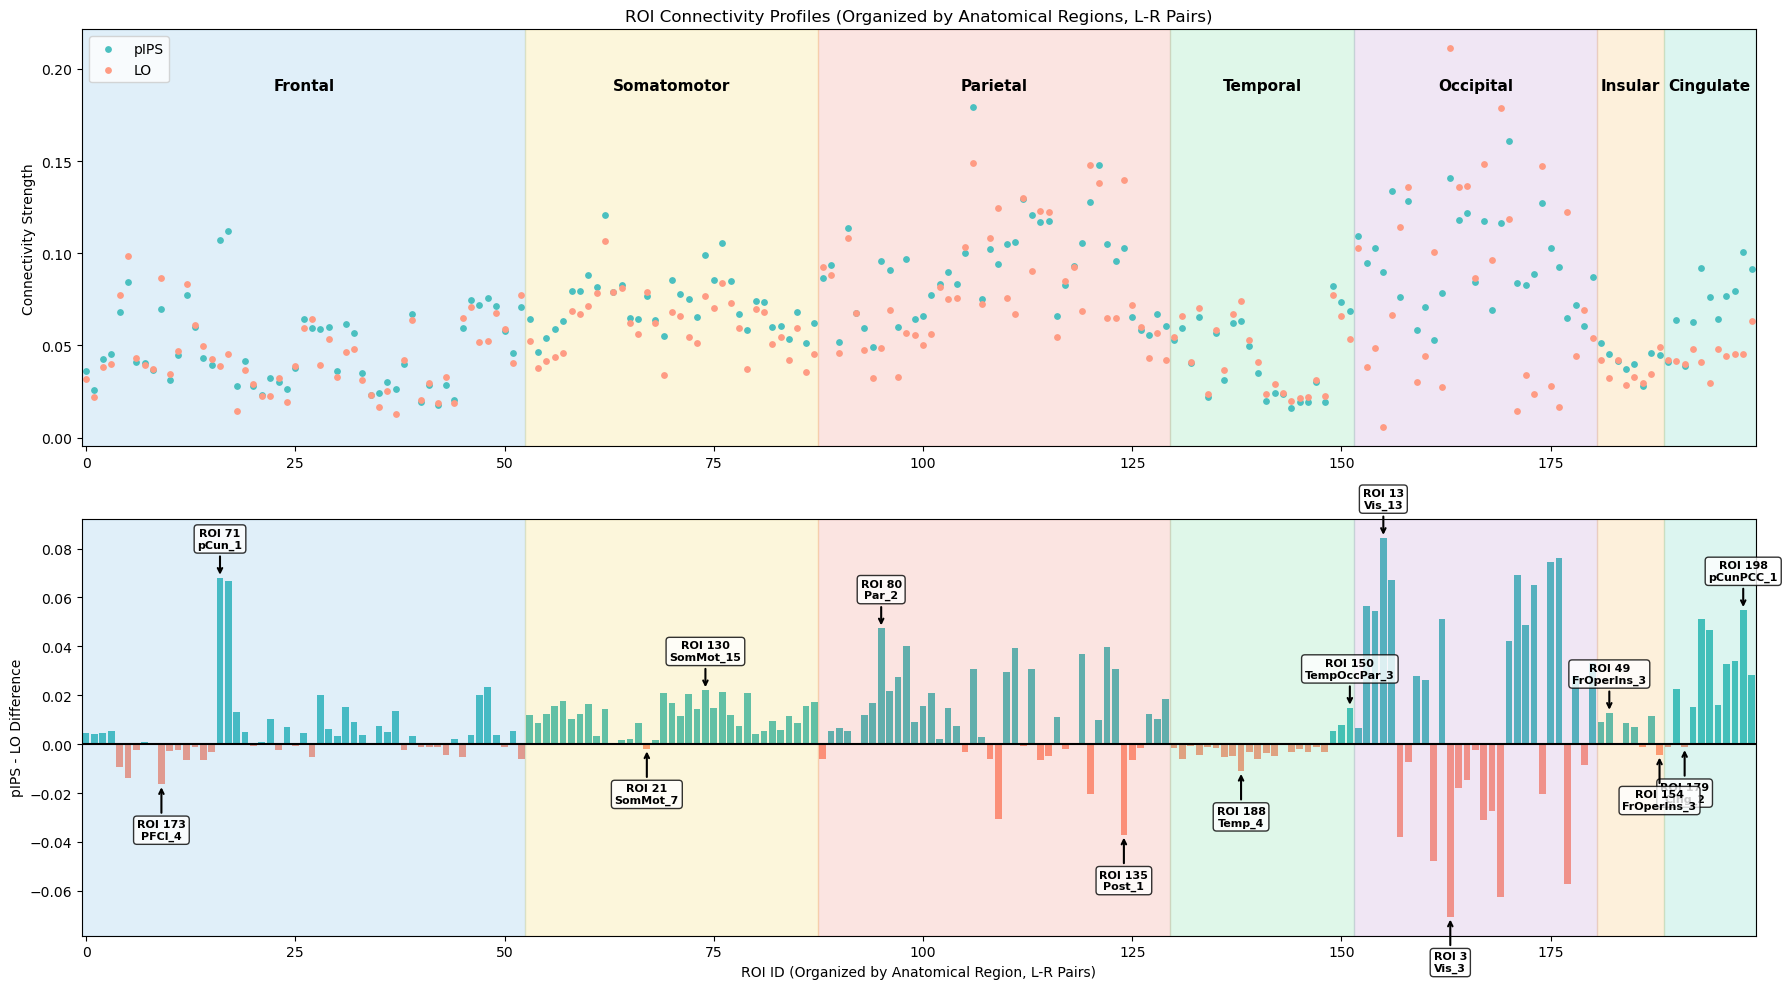

Figure created successfully!

Peak and bottom ROIs by anatomical lobe:

Cingulate Lobe:
  Peak (pIPS > LO): ROI 198 (pCunPCC_1), Diff = 0.055
  Bottom (LO > pIPS): ROI 179 (Cing_2), Diff = -0.001

Frontal Lobe:
  Peak (pIPS > LO): ROI 71 (pCun_1), Diff = 0.068
  Bottom (LO > pIPS): ROI 173 (PFCl_4), Diff = -0.016

Insular Lobe:
  Peak (pIPS > LO): ROI 49 (FrOperIns_3), Diff = 0.013
  Bottom (LO > pIPS): ROI 154 (FrOperIns_3), Diff = -0.004

Occipital Lobe:
  Peak (pIPS > LO): ROI 13 (Vis_13), Diff = 0.084
  Bottom (LO > pIPS): ROI 3 (Vis_3), Diff = -0.071

Parietal Lobe:
  Peak (pIPS > LO): ROI 80 (Par_2), Diff = 0.047
  Bottom (LO > pIPS): ROI 135 (Post_1), Diff = -0.037

Somatomotor Lobe:
  Peak (pIPS > LO): ROI 130 (SomMot_15), Diff = 0.022
  Bottom (LO > pIPS): ROI 21 (SomMot_7), Diff = -0.002

Temporal Lobe:
  Peak (pIPS > LO): ROI 150 (TempOccPar_3), Diff = 0.015
  Bottom (LO > pIPS): ROI 188 (Temp_4), Diff = -0.011


In [ ]:
# Connectivity Profile Figure
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Define paths
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
output_dir = f'{results_dir}/connectivity_comparison'
os.makedirs(output_dir, exist_ok=True)

# Load the results data
results_file = f'{output_dir}/bilateral_connectivity_fingerprint_results.csv'

try:
    # Load data from the saved CSV file
    results_df = pd.read_csv(results_file)
    
    # Extract the required data
    mean_pips = results_df['pIPS_Connectivity'].values
    mean_lo = results_df['LO_Connectivity'].values
    diff_profile = results_df['Difference'].values
    roi_names = results_df['ROI_Name'].values
    roi_ids = results_df['ROI_ID'].values
    n_rois = len(mean_pips)
    
    # Function to map Schaefer networks to anatomical lobes
    def map_to_anatomical_lobe(roi_name):
        # Special handling for Wang atlas ROIs
        if 'pIPS' in roi_name:
            return 'Parietal'
        elif 'LO' in roi_name:
            return 'Temporal'
        
        # Map Schaefer networks to anatomical regions
        if 'Vis' in roi_name:
            return 'Occipital'
        elif 'SomMot' in roi_name:
            return 'Somatomotor'
        elif 'DorsAttn' in roi_name:
            if 'Par' in roi_name or 'IPL' in roi_name or 'IPS' in roi_name:
                return 'Parietal'
            elif 'Temp' in roi_name or 'MT' in roi_name:
                return 'Temporal'
            else:
                return 'Parietal'
        elif 'SalVentAttn' in roi_name:
            if 'Ins' in roi_name:
                return 'Insular'
            elif 'Cing' in roi_name or 'ACC' in roi_name:
                return 'Cingulate'
            elif 'Temp' in roi_name:
                return 'Temporal'
            elif 'Par' in roi_name:
                return 'Parietal'
            else:
                return 'Frontal'
        elif 'Limbic' in roi_name:
            if 'Temp' in roi_name:
                return 'Temporal'
            else:
                return 'Frontal'
        elif 'Cont' in roi_name:
            if 'Par' in roi_name or 'IPL' in roi_name or 'IPS' in roi_name:
                return 'Parietal'
            elif 'Temp' in roi_name or 'MT' in roi_name:
                return 'Temporal'
            elif 'Cing' in roi_name:
                return 'Cingulate'
            else:
                return 'Frontal'
        elif 'Default' in roi_name:
            if 'Par' in roi_name:
                return 'Parietal'
            elif 'Temp' in roi_name:
                return 'Temporal'
            elif 'PCC' in roi_name or 'Cing' in roi_name:
                return 'Cingulate'
            else:
                return 'Frontal'
        else:
            return 'Other'
    
    # Clean up ROI names for better labeling
    def clean_roi_name(roi_name):
        if isinstance(roi_name, bytes):
            roi_name = roi_name.decode('utf-8')
        
        # Remove common prefixes and suffixes
        cleaned = roi_name.replace('7Networks_', '')
        
        # Extract just the region part, removing hemisphere and network
        parts = cleaned.split('_')
        if len(parts) > 2:
            return parts[-2] + '_' + parts[-1]
        elif len(parts) > 1:
            return parts[-1]
        else:
            return cleaned
    
    # Determine hemisphere and base region for organizing pairs
    def get_hemisphere_and_region(roi_name):
        if isinstance(roi_name, bytes):
            roi_name = roi_name.decode('utf-8')
        
        # Determine hemisphere 
        if 'LH' in roi_name:
            hemisphere = 'L'
        elif 'RH' in roi_name:
            hemisphere = 'R'
        else:
            hemisphere = 'X'  # For ROIs without clear hemisphere
        
        # Extract base region by removing hemisphere and number
        # This is a simplified approach, might need refinement
        cleaned = roi_name.replace('7Networks_', '')
        cleaned = cleaned.replace('LH_', '').replace('RH_', '')
        
        # Remove trailing numbers which often differentiate regions
        base_region = re.sub(r'_\d+$', '', cleaned)
        
        return hemisphere, base_region
    
    # Add anatomical lobe and hemisphere information to the dataframe
    results_df['Anatomical_Lobe'] = results_df['ROI_Name'].apply(map_to_anatomical_lobe)
    results_df['Clean_Name'] = results_df['ROI_Name'].apply(clean_roi_name)
    
    # Extract hemisphere and base region info
    hemisphere_region = results_df['ROI_Name'].apply(get_hemisphere_and_region)
    results_df['Hemisphere'] = [h for h, r in hemisphere_region]
    results_df['Base_Region'] = [r for h, r in hemisphere_region]
    
    # Define a manual order for anatomical lobes
    lobe_order = [
        'Frontal',
        'Somatomotor',
        'Parietal',
        'Temporal',
        'Occipital',
        'Insular',
        'Cingulate',
        'Other'
    ]
    
    # Create a category for sorting based on the defined order
    lobe_cat = pd.Categorical(results_df['Anatomical_Lobe'], categories=lobe_order, ordered=True)
    results_df['Lobe_Sorted'] = lobe_cat
    
    # Define a consistent color palette for brain lobes
    lobe_colors = {
        'Frontal': '#3498db',     # Blue
        'Somatomotor': '#f1c40f', # Yellow
        'Parietal': '#e74c3c',    # Red
        'Temporal': '#2ecc71',    # Green
        'Occipital': '#9b59b6',   # Purple
        'Insular': '#f39c12',     # Orange
        'Cingulate': '#1abc9c',   # Turquoise
        'Other': '#7f8c8d'        # Gray
    }
    
    # Custom sorting function to group by lobe, then by base region, then by hemisphere (L then R)
    def custom_sort(row):
        lobe_idx = lobe_order.index(row['Anatomical_Lobe']) if row['Anatomical_Lobe'] in lobe_order else 999
        hemi_idx = 0 if row['Hemisphere'] == 'L' else 1 if row['Hemisphere'] == 'R' else 2
        return (lobe_idx, row['Base_Region'], hemi_idx)
    
    # Sort using the custom function
    results_df['sort_key'] = results_df.apply(custom_sort, axis=1)
    results_df = results_df.sort_values('sort_key')
    
    # Get the new order
    sorted_indices = results_df.index.values
    
    # Extract reordered data
    mean_pips_sorted = results_df['pIPS_Connectivity'].values
    mean_lo_sorted = results_df['LO_Connectivity'].values
    diff_profile_sorted = results_df['Difference'].values
    
    # Find peak (highest) and bottom (lowest) ROI in each lobe
    peak_bottom_indices = []
    lobe_groups = results_df.groupby('Anatomical_Lobe')
    
    for lobe, group in lobe_groups:
        if len(group) > 0:
            # Get highest difference (most pIPS-preferring) ROI
            peak_idx = group['Difference'].idxmax()
            peak_bottom_indices.append(peak_idx)
            
            # Get lowest difference (most LO-preferring) ROI
            bottom_idx = group['Difference'].idxmin()
            peak_bottom_indices.append(bottom_idx)
    
    # Create the visualization
    plt.figure(figsize=(18, 10))
    
    # Top subplot - connectivity profiles with dots, organized by lobe
    plt.subplot(2, 1, 1)
    x = np.arange(n_rois)
    
    # Plot background colors for different lobes
    current_lobe = None
    start_idx = 0
    
    for i, idx in enumerate(sorted_indices):
        lobe = results_df.iloc[i]['Anatomical_Lobe']
        if lobe != current_lobe:
            if current_lobe is not None:
                # Mark the region for the previous lobe
                plt.axvspan(start_idx - 0.5, i - 0.5, alpha=0.15, 
                           color=lobe_colors[current_lobe])
                # Add label in the middle of the region
                plt.text((start_idx + i - 1) / 2, max(mean_pips_sorted) * 1.05, 
                        current_lobe, ha='center', fontsize=11, fontweight='bold')
            current_lobe = lobe
            start_idx = i
    
    # Add the last region
    plt.axvspan(start_idx - 0.5, n_rois - 0.5, alpha=0.15, 
               color=lobe_colors[current_lobe])
    plt.text((start_idx + n_rois - 1) / 2, max(mean_pips_sorted) * 1.05, 
            current_lobe, ha='center', fontsize=11, fontweight='bold')
    
    # Plot the points
    plt.scatter(x, mean_pips_sorted, color='#4ac0c0', s=15, label='pIPS')
    plt.scatter(x, mean_lo_sorted, color='#ff9b83', s=15, label='LO')
    
    # Plot
    #plt.plot(x, mean_pips_sorted, color='#4ac0c0', linewidth=2, marker='o', markersize=5, label='pIPS')
    #plt.plot(x, mean_lo_sorted, color='#ff9b83', linewidth=2, marker='o', markersize=5, label='LO')
    
    plt.ylabel('Connectivity Strength')
    plt.title('ROI Connectivity Profiles (Organized by Anatomical Regions, L-R Pairs)')
    plt.legend(loc='upper left')
    plt.xlim(-0.5, n_rois - 0.5)
    
    # Bottom subplot - difference
    plt.subplot(2, 1, 2)
    colors = ['#4ac0c0' if val > 0 else '#ff9b83' for val in diff_profile_sorted]
    plt.bar(x, diff_profile_sorted, color=colors)
    plt.axhline(y=0, color='black', linestyle='-')
    
    # Add background colors for different lobes (same as top plot)
    current_lobe = None
    start_idx = 0
    
    for i, idx in enumerate(sorted_indices):
        lobe = results_df.iloc[i]['Anatomical_Lobe']
        if lobe != current_lobe:
            if current_lobe is not None:
                plt.axvspan(start_idx - 0.5, i - 0.5, alpha=0.15, 
                           color=lobe_colors[current_lobe])
            current_lobe = lobe
            start_idx = i
    
    # Add the last region
    plt.axvspan(start_idx - 0.5, n_rois - 0.5, alpha=0.15, 
               color=lobe_colors[current_lobe])
    
    # Label peak and bottom ROIs in the difference plot
    for peak_idx in peak_bottom_indices:
        # Find position in sorted array
        position = np.where(sorted_indices == peak_idx)[0][0]
        roi_id = results_df.loc[peak_idx, 'ROI_ID']
        roi_name = results_df.loc[peak_idx, 'Clean_Name']
        diff_value = results_df.loc[peak_idx, 'Difference']
        
        # Add annotation for ROI
        plt.annotate(f'ROI {roi_id}\n{roi_name}',
                    xy=(position, diff_value),
                    xytext=(0, 20 if diff_value >= 0 else -25),
                    textcoords='offset points',
                    ha='center',
                    va='bottom' if diff_value >= 0 else 'top',
                    fontsize=8,
                    fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8),
                    arrowprops=dict(arrowstyle='->', lw=1.5))
    
    plt.ylabel('pIPS - LO Difference')
    plt.xlabel('ROI ID (Organized by Anatomical Region, L-R Pairs)')
    plt.xlim(-0.5, n_rois - 0.5)
    
    plt.tight_layout()
    
    # Display the figure
    plt.show()
    
    # Uncomment to save
    # plt.savefig(f'{output_dir}/bilateral_connectivity_profiles_anatomical_lr_pairs.png', dpi=300)
    
    print("Figure created successfully!")
    
    # Print peak and bottom ROIs by lobe
    print("\nPeak and bottom ROIs by anatomical lobe:")
    for lobe, group in lobe_groups:
        print(f"\n{lobe} Lobe:")
        if len(group) > 0:
            # Peak (pIPS-preferring) ROI
            peak_row = group.loc[group['Difference'].idxmax()]
            print(f"  Peak (pIPS > LO): ROI {peak_row['ROI_ID']} ({peak_row['Clean_Name']}), " + 
                  f"Diff = {peak_row['Difference']:.3f}")
            
            # Bottom (LO-preferring) ROI
            bottom_row = group.loc[group['Difference'].idxmin()]
            print(f"  Bottom (LO > pIPS): ROI {bottom_row['ROI_ID']} ({bottom_row['Clean_Name']}), " + 
                  f"Diff = {bottom_row['Difference']:.3f}")
    
except FileNotFoundError:
    print(f"Error: Results file not found at {results_file}")
    print("You need to run the analysis first to generate the results file.")
except Exception as e:
    print(f"Error creating figure: {e}")